In [1]:
import io
import subprocess
import os
import glob
import sys
import pwd

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings
import statsmodels.stats.multitest as smm
import json

from pathlib import Path
from midas import m
from datetime import datetime, date
import altair as alt

# gh specific
sys.path.append('/ghsfa/projects/pharma/shared_scripts/')
import bibp.functions as functions
import hgvslib.pHGVS as pHGVS  ## do a pull on the hgvslib git repo

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/ILD_prediction_model_12042024"

## LDT Clincal Samples

In [5]:
# Pull the clinical data
query = "SELECT * FROM gh_sample WHERE sample_type = 'Clinical' AND panel LIKE '%Sirius%' AND use_case = 'cgp'"
df = functions.run_sql_query(query)

print("Total size of clinical samples is " + str(df.shape[0]) + "\n") 
print("Total unique sample size of clinical samples is " + str(df.run_sample_id.nunique()) + "\n")
df.head()

Total size of clinical samples is 61713

Total unique sample size of clinical samples is 57755



,runid,run_sample_id,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,flowcell_pipeline_version,sample_set,analyte_type,patient_id
0,230823_A02056_0020_BH7GHYDSX7,03_5774414_Screening,AGGTTACCTG,Unknown,Clinical,2023-08-25 20:35:00-07:00,Sirius_v1.0,None,Sirius-1.1.1-RLS,None,None,Guardant 360,None,CRC,NaN,Sirius_LDT_Soft_v2.0,None,None,None,B00457797,cgp,None,None,None,None
1,230823_A02056_0019_AH7CH2DSX7,01_5745746_Cycle1Day1,TCAGAGTCGC,Unknown,Clinical,2023-08-25 20:31:32-07:00,Sirius_v1.0,None,Sirius-1.1.1-RLS,None,None,Guardant 360,None,CRC,NaN,Sirius_LDT_Soft_v2.0,None,None,None,B00457784,cgp,None,None,None,None
2,230823_A02056_0020_BH7GHYDSX7,03_10699636_Cycle1Day1,ACATACGTCC,Unknown,Clinical,2023-08-25 20:35:00-07:00,Sirius_v1.0,None,Sirius-1.1.1-RLS,None,None,Guardant 360,None,CRC,NaN,Sirius_LDT_Soft_v2.0,None,None,None,B00457822,cgp,None,None,None,None
3,230823_A02056_0019_AH7CH2DSX7,01_5672359_Screening,TCCTTACCGG,Unknown,Clinical,2023-08-25 20:31:32-07:00,Sirius_v1.0,None,Sirius-1.1.1-RLS,None,None,Guardant 360,None,CRC,NaN,Sirius_LDT_Soft_v2.0,None,None,None,B00457843,cgp,None,None,None,None
4,230823_A02056_0020_BH7GHYDSX7,03_10699620_Cycle1Day1,ACAAGTGAGG,Unknown,Clinical,2023-08-25 20:35:00-07:00,Sirius_v1.0,None,Sirius-1.1.1-RLS,None,None,Guardant 360,None,CRC,NaN,Sirius_LDT_Soft_v2.0,None,None,None,B00457824,cgp,None,None,None,None


In [6]:
# Pull the breast cancer clinical samples
# df["cancer_type"].value_counts(dropna=False)

df_breast = df[df['cancer_type'].str.contains('breast', case=False, na=False)]
df_breast["cancer_type"].value_counts(dropna=False)

print("Total size of clinical breast cancer samples is " + str(df_breast.shape[0]) + "\n") 
print("Total unique sample size of clinical breast cancer samples is " + str(df_breast.run_sample_id.nunique()) + "\n")

Total size of clinical breast cancer samples is 11051

Total unique sample size of clinical breast cancer samples is 10366



In [7]:
# Select those samples sequenced in March - Sep 2024
df_breast_inhouse = df_breast[df_breast['runid'].str.startswith(("2403", "2404", "2405", "2406", "2407", "2408", "2409", "2410", "2411"))].copy()
print("Total size of clinical breast cancer inhouse samples is " + str(df_breast_inhouse.shape[0]) + "\n") 
print("Total unique sample size of clinical breast cancer inhouse samples is " + str(df_breast_inhouse.run_sample_id.nunique()) + "\n")

Total size of clinical breast cancer inhouse samples is 9735

Total unique sample size of clinical breast cancer inhouse samples is 9149



## Get the QC of the clinical data

In [5]:
df_breast_inhouse_qc = functions.run_sql_query("SELECT * FROM sample_qc WHERE run_sample_id IN {}".format(tuple(df_breast_inhouse['run_sample_id'].unique())))
df_breast_inhouse_qc.head()

,runid,run_sample_id,category,metric,verbose_name,unit,value,operator,threshold,status,decimal_places,tumor_type,bip_version,sample_set,metric_analyte_type
0,240630_A00441_1034_BHFVCTDSXC,A057166601,sample,hotspot_non_singleton_coverage,Non-singleton families,families,3483.000,>=,500.0,PASS,1.0,None,None,None,None
1,240630_A00441_1034_BHFVCTDSXC,A057166601,sample,hypo_on_target_rate,Hypo On Target Rate,None,0.850,>=,0.4,PASS,2.0,None,None,None,None
2,240630_A00441_1034_BHFVCTDSXC,A057166601,sample,sample_contamination_pct,Family contamination,%,0.020,<=,0.5,PASS,2.0,None,None,None,None
3,240630_A00441_1034_BHFVCTDSXC,A057166601,sample,contam_vscore,Germline contamination,genes,5.000,<=,50.0,PASS,0.0,None,None,None,None
4,240630_A00441_1034_BHFVCTDSXC,A057166601,sample,hotspot_umol_gc_iqr,GC Bias,None,1.333,<=,4.0,PASS,3.0,None,None,None,None


In [6]:
# Subset the qc passed samples
df_breast_inhouse_qc_pass = df_breast_inhouse_qc.query('verbose_name == "Passing Sample AutoQC Tests" & status == "PASS"')[["runid", "run_sample_id"]].drop_duplicates()
sub_df = df_breast_inhouse_qc_pass.merge(df_breast_inhouse, on=["runid", "run_sample_id"], how="inner")

# Drop duplicates
uniq_sub_df = sub_df.sort_values(by=["runid"], ascending=True).drop_duplicates(subset=["run_sample_id"], keep="last")
print("Total size of clinical breast cancer samples that passed the QC is " + str(uniq_sub_df.shape[0]) + "\n") 
print("Total unique sample size of clinical breast cancer samples that passed the QC is " + str(uniq_sub_df.run_sample_id.nunique()))

Total size of clinical breast cancer samples that passed the QC is 7613

Total unique sample size of clinical breast cancer samples that passed the QC is 7613


## Data processing

In [ ]:
# from tqdm import tqdm
# tqdm.pandas()

In [7]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            for folder in folders:
                primary_fc_dir = folder
                # Check if there is a 'sirius' folder under the primary fc_dir. This is for Sirius 1.5 folder structure change.
                if os.path.exists(os.path.join(primary_fc_dir, "sirius")):
                    primary_fc_dir = os.path.join(primary_fc_dir, "sirius")
                df.loc[index, 'fc_dir'] = primary_fc_dir
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_breast_samples, df_no_found = add_fc_dir_column(uniq_sub_df)

# # Wrap the input DataFrame with tqdm to show progress
# tqdm.pandas(desc="Processing rows")
# df_breast_samples, df_no_found = add_fc_dir_column(uniq_sub_df.progress_apply(lambda x: x, axis=1))

print("Total sample size of with fc_dir is " + str(df_breast_samples.shape[0]) + "\n") 
print("Total sample size of with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_breast_samples.head()


Total sample size of with fc_dir is 7613

Total sample size of with NO fc_dir is 0



,runid,run_sample_id,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,flowcell_pipeline_version,sample_set,analyte_type,patient_id,fc_dir
30,240301_A01112_0466_BHTGMGDSX7,A097485001,CATTGCCGTA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,None,Sirius-1.1.2-RLS,None,None,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,None,None,None,A0974850,cgp,None,None,None,None,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441
90,240301_A01112_0466_BHTGMGDSX7,A097735001,GATCGGTAGA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,None,Sirius-1.1.2-RLS,None,None,Guardant 360,GH_G360_3_0,Breast Carcinoma,77.0,Sirius_LDT_Soft_v2.0,None,None,None,A0977350,cgp,None,None,None,None,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441
89,240301_A01112_0466_BHTGMGDSX7,A097734601,GTTCTAGGCT,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,None,Sirius-1.1.2-RLS,None,None,Guardant 360,GH_G360_3_0,Breast Carcinoma,44.0,Sirius_LDT_Soft_v2.0,None,None,None,A0977346,cgp,None,None,None,None,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441
55,240301_A01112_0467_AHTGFYDSX7,A097628801,TGAACTAACG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,None,Sirius-1.1.2-RLS,None,None,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,None,None,None,A0976288,cgp,None,None,None,None,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759
56,240301_A01112_0467_AHTGFYDSX7,A097629101,CAGGTCTGCG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,None,Sirius-1.1.2-RLS,None,None,Guardant 360,GH_G360_3_0,Breast Carcinoma,68.0,Sirius_LDT_Soft_v2.0,None,None,None,A0976291,cgp,None,None,None,None,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759


In [55]:
# Pull the total cfDNA yeild 

# SQL query
query = """
SELECT *
FROM total_yield
"""

# Run the query using your existing function
sample_df = functions.run_sql_query(query)

print("Total size of GHDB is " + str(sample_df.shape[0]) + "\n") 
print("Total unique sample size of GHDB is " + str(sample_df.run_sample_id.nunique()) + "\n")

# Drop duplicates 
df_gh_sample_dedup = sample_df.drop_duplicates(subset=["run_sample_id"])
print("Total size of this RUO summary data that pulled from gh_sample database is " + str(df_gh_sample_dedup.shape[0]) + "\n") 
df_gh_sample_dedup.head()

Total size of GHDB is 179647

Total unique sample size of GHDB is 160422

Total size of this RUO summary data that pulled from gh_sample database is 160422



,run_sample_id,runid,request_id,total_yield
0,SA0292976,221031_A01902_0031_BH3W7FDSX5,SA0292976,174.200
1,SA0236115,221031_A01902_0031_BH3W7FDSX5,SA0236115,17.095
2,SA0170056,221031_A01902_0031_BH3W7FDSX5,SA0170056,81.900
3,SA0271541,221031_A01902_0031_BH3W7FDSX5,SA0271541,75.400
4,SA0243138,221031_A01902_0031_BH3W7FDSX5,SA0243138,38.805


In [56]:
# Merge the cfDNA 
df_breast_samples = df_breast_samples.merge(df_gh_sample_dedup[["run_sample_id", "total_yield"]], on = "run_sample_id", how = "left")
print(df_breast_samples.total_yield.isnull().size)

7613


### Get the treatment info

In [57]:
# Get the treatment information from the clincical summary data
df_clinical_summary = pd.read_table("/ghsfa/datawarehouse/data_platform/latest/clinical_summaries.tsv")
df_clinical_summary.head()

,accn_id,alt_description,alt_method,alt_name,alt_value,alteration,alteration_detected,alteration_synonymous,aminoacid_mutation,amplification,approved_in_other_diseases,baseline_sampleid,bloodcolldate,cancer_category,cancerother,cancerstage,cancertype,category,cdna,chromosome,clon_frxn,clon2,clonal,cn,copy_number_loss,copynumber,ctdna_velocity,diagnosisdate,downstream_chromosome,downstream_gene,downstream_position,dp_alt_name,exon,finalreportdate,gene,gene_key,gh_patientgender,gh_requesttype,ispathreportavailable,mr_ctdnachangepercentage,mr_ctdnalevelchange,mr_detected,mr_name,mr_score,mr_value,msi_high,msi_score,msi_status,mut_type,mutation_nt,num_alts,panelversion,parentrequestid,patientage,patientgender,patientrecordid,pdl1_report_date,pdl1_score_type,pdl1_status,pdl1_tumor_fraction,pdl1_value,percentage,phasing,position,projectid,receiveddate,reporting_category,reportstatus,requeststudyid,requesttype,rpt_cancertype,rpt_category,runid,sampleid,serial_test,therapies_approved_in_disease,therapies_associated_resistance,tissueavailable,tmb_category,tmb_score,totaltests,treatmentnotes,trial,tumor_fraction,type,updated_cancer_type,vus
0,A0892520,NaN,deletion,P2514fs,0.2%,P2514fs,True,NaN,P2514fs,NaN,NaN,NaN,2023-11-07,NaN,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",breast phyllodes tumor,Other,c.7541_7542delCT,9,0.500000,0.500000,subclonal,1.0,NaN,NaN,NaN,12/2019,NaN,NaN,NaN,P2514fs,34.0,2023-11-16,NOTCH1,A089252001_NOTCH1,F,Clinical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT DETECTED,1.0,Low,indel,CAG>C,7,2.12,NaN,63.0,Female,100568058,NaN,NaN,NaN,NaN,NaN,0.20,NaN,139390648.0,GH2_12,2023-11-08,protein_coding,FINAL,ClinicalStudy,Clinical,breast phyllodes tumor,Other,231111_A00274_0953_AHKJMHDSX7,A089252001,1.0,NaN,NaN,NaN,Not evaluable,NaN,1.0,NaN,No,NaN,indel,NaN,NaN
1,A0701824,NaN,deletion,D1313fs,3.6%,D1313fs,True,NaN,D1313fs,NaN,Selumetinib,NaN,2023-04-05,Other,Breast phyllodes tumor,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",other,Other,c.3938_3941delATTG,17,0.818182,0.818182,clonal,1.0,NaN,NaN,NaN,6/18/21,NaN,NaN,NaN,D1313fs,29.0,2023-04-14,NF1,A070182401_NF1,F,Clinical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT DETECTED,2.0,Low,indel,CTGAT>C,2,2.11,NaN,53.0,Female,100457650,NaN,NaN,NaN,NaN,NaN,3.60,NaN,29563000.0,GHI_05,2023-04-06,protein_coding,FINAL,GHStudy,Clinical,breast phyllodes tumor,Other,230408_NB551235_0758_AHLNF3BGXN,A070182401,1.0,NaN,NaN,NaN,TMB evaluated,2.0,1.0,NaN,Yes,NaN,indel,"Cancer, Other",NaN
2,A0892520,NaN,substitution,Q61R,0.02%,Q61R,True,NaN,Q61R,NaN,NaN,NaN,2023-11-07,NaN,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",breast phyllodes tumor,Other,c.182A>G,12,0.050000,0.050000,subclonal_minor,1.0,NaN,NaN,NaN,12/2019,NaN,NaN,NaN,Q61R,3.0,2023-11-16,KRAS,A089252001_KRAS,F,Clinical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT DETECTED,1.0,Low,missense,T>C,7,2.12,NaN,63.0,Female,100568058,NaN,NaN,NaN,NaN,NaN,0.02,NaN,25380276.0,GH2_12,2023-11-08,protein_coding,FINAL,ClinicalStudy,Clinical,breast phyllodes tumor,Other,231111_A00274_0953_AHKJMHDSX7,A089252001,1.0,NaN,NaN,NaN,Not evaluable,NaN,1.0,NaN,Yes,NaN,snv,NaN,NaN
3,A0701824,NaN,substitution,Promoter SNV,4.4%,NaN,True,NaN,NaN,NaN,NaN,NaN,2023-04-05,Other,Breast phyllodes tumor,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",other,Other,c.-124C>T,5,1.000000,1.000000,clonal,1.0,NaN,NaN,NaN,6/18/21,NaN,NaN,NaN,Promoter SNV,1.0,2023-04-14,TERT,A070182401_TERT,F,Clinical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT DETECTED,2.0,Low,promoter,G>A,2,2.11,NaN,53.0,Female,100457650,NaN,NaN,NaN,NaN,NaN,4.40,NaN,1295228.0,GHI_05,2023-04-06,promoter,FINAL,GHStudy,Clinical,breast phyllodes tumor,Other,230408_NB551235_0758_AHLNF3BGXN,A070182401,1.0,NaN,NaN,NaN,TMB evaluated,2.0,1.0,NaN,No,NaN,snv,"Cancer, Other",NaN
4,A0892520,NaN,substitution,F115C,0.3%,F115C,True,NaN,F115C,NaN,NaN,NaN,2023-11-07,NaN,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",breast phyllodes tumor,Other,c.344T>G,22,0.750000,0.750000,clonal,1.0,NaN,NaN,NaN,12/2019,NaN,NaN,NaN,F1

In [58]:
# Subset the data with clinical info
clinical_bc_samples = df_breast_samples.request_id.to_list()
df_clinical_summary_bc = df_clinical_summary[df_clinical_summary['accn_id'].isin(clinical_bc_samples)]

# Do the addtioinal filter for breast cancer samples to remove the inconsistent cancer label
df_clinical_summary_bc = df_clinical_summary_bc[df_clinical_summary_bc['cancer_category'] == "Breast"]

# Drop duplicates
df_clinical_summary_bc_dedup = df_clinical_summary_bc.drop_duplicates(subset=["accn_id"])
print("Total size of this clinical summary of breast cancer is " + str(df_clinical_summary_bc_dedup.shape[0])) 

# Save the data
df_clinical_summary_bc_dedup.to_csv(f"{work_dir}/df_clinical_summary_bc_dedup.csv", index = False)
df_clinical_summary_bc_dedup.head()

Total size of this clinical summary of breast cancer is 7496


,accn_id,alt_description,alt_method,alt_name,alt_value,alteration,alteration_detected,alteration_synonymous,aminoacid_mutation,amplification,approved_in_other_diseases,baseline_sampleid,bloodcolldate,cancer_category,cancerother,cancerstage,cancertype,category,cdna,chromosome,clon_frxn,clon2,clonal,cn,copy_number_loss,copynumber,ctdna_velocity,diagnosisdate,downstream_chromosome,downstream_gene,downstream_position,dp_alt_name,exon,finalreportdate,gene,gene_key,gh_patientgender,gh_requesttype,ispathreportavailable,mr_ctdnachangepercentage,mr_ctdnalevelchange,mr_detected,mr_name,mr_score,mr_value,msi_high,msi_score,msi_status,mut_type,mutation_nt,num_alts,panelversion,parentrequestid,patientage,patientgender,patientrecordid,pdl1_report_date,pdl1_score_type,pdl1_status,pdl1_tumor_fraction,pdl1_value,percentage,phasing,position,projectid,receiveddate,reporting_category,reportstatus,requeststudyid,requesttype,rpt_cancertype,rpt_category,runid,sampleid,serial_test,therapies_approved_in_disease,therapies_associated_resistance,tissueavailable,tmb_category,tmb_score,totaltests,treatmentnotes,trial,tumor_fraction,type,updated_cancer_type,vus
1920840,A0976514,NaN,substitution,S234F,1.4%,S234F,True,NaN,S234F,NaN,NaN,NaN,2024-02-28,Breast,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",breast cancer,Breast,c.701C>T,3,0.538462,0.538462,clonal,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S234F,5.0,2024-03-12,CTNNB1,A097651401_CTNNB1,F,Clinical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT DETECTED,2.0,Low,missense,C>T,9,3.0,NaN,70.0,Female,100530834,NaN,NaN,NaN,NaN,NaN,1.4,NaN,41267030.0,GH_G360_3_0,2024-02-29,protein_coding,FINAL,ClinicalStudy,Clinical,breast carcinoma,BREAST,240308_A01552_0406_BHTJ2HDSX7,A097651401,1.0,NaN,NaN,NaN,Low,19.67,2.0,NaN,No,NaN,snv,Breast Cancer,true
1920875,A0966371,NaN,insertion,R331fs,0.7%,R331fs,True,NaN,R331fs,NaN,NaN,NaN,2024-02-23,Breast,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",breast cancer,Breast,c.985_991dupTGGAGGA,10,0.636364,0.636364,clonal,1.0,NaN,NaN,NaN,2021-08-24,NaN,NaN,NaN,R331fs,5.0,2024-03-05,GATA3,A096637101_GATA3,F,Clinical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT DETECTED,8.0,Low,indel,C>CTGGAGGA,4,3.0,NaN,47.0,Female,100615578,NaN,NaN,NaN,NaN,NaN,0.7,NaN,8111495.0,GH_G360_3_0,2024-02-28,protein_coding,FINAL,ClinicalStudy,Clinical,breast carcinoma,BREAST,240301_A01112_0467_AHTGFYDSX7,A096637101,1.0,NaN,NaN,NaN,Not evaluable,NaN,1.0,Abraxane+Gemzar,No,NaN,indel,Breast Cancer,NaN
1921002,A0978412,NaN,substitution,E588Q,3.2%,E588Q,True,NaN,E588Q,NaN,NaN,NaN,2024-02-28,Breast,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",breast cancer,Breast,c.1762G>C,15,0.542373,0.542373,clonal,1.0,NaN,NaN,NaN,6/30/2016,NaN,NaN,NaN,E588Q,16.0,2024-03-06,NTRK3,A097841201_NTRK3,F,Clinical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT DETECTED,4.0,Low,missense,C>G,28,3.0,NaN,70.0,Female,100623231,NaN,NaN,NaN,NaN,NaN,3.2,NaN,88476370.0,GH_G360_3_0,2024-02-29,protein_coding,FINAL,ClinicalStudy,Clinical,breast carcinoma,BREAST,240303_A00770_0876_AHWKTHDSX7,A097841201,1.0,NaN,NaN,NaN,High,62.13,1.0,NaN,No,NaN,snv,Breast Cancer,true
1921058,A0978587,NaN,substitution,H1047R,5.0%,H1047R,True,NaN,H1047R,NaN,NaN,NaN,2024-03-01,Breast,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",breast cancer,Breast,c.3140A>G,3,0.537634,0.537634,clonal,1.0,NaN,NaN,NaN,2023-06-14,NaN,NaN,NaN,H1047R,21.0,2024-03-10,PIK3CA,A097858701_PIK3CA,F,Clinical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT DETECTED,4.0,Low,missense,A>G,14,3.0,NaN,64.0,Female,100514150,NaN,NaN,NaN,NaN,NaN,5.0,NaN,178952085.0,GH_G360_3_0,2024-03-02,protein_coding,FINAL,ClinicalStudy,Clinical,breast carcinoma,BREAST,240306_A01422_0546_BHTJLLDSX7,A097858701,2.0,"Alpelisib+fulvestrant, Capivasertib+fulvestrant",NaN,NaN,High,31.53,2.0,NaN,Yes,NaN,snv,Breast Cancer,NaN
1921094,A0980958,NaN,substitution,A1931V,0.2%,A1931V,True,NaN,A1931V,NaN,NaN,NaN,2024-02-29,Breast,NaN,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",breast cancer,Breast,c.5792C>T,11,0.008547,0.008547,sub

In [8]:
# Read the data
df_clinical_summary_bc_dedup = pd.read_csv(f"{work_dir}/df_clinical_summary_bc_dedup.csv")


In [60]:
# Remove the mislabeled cancer type samples
df_clinical_summary_bc_dedup_rename = df_clinical_summary_bc_dedup.reset_index().rename(columns={"accn_id": "request_id"})

# Subset the data with clinical info
clinical_bc_samples = df_clinical_summary_bc_dedup_rename.request_id.to_list()
df_breast_samples = df_breast_samples[df_breast_samples['request_id'].isin(clinical_bc_samples)]
print("Total size of this clinical summary of breast cancer after removing mislabel is " + str(df_breast_samples.shape[0])) 

# Save the data
df_breast_samples.to_csv(f"{work_dir}/df_breast_samples.csv", index = False)
df_breast_samples.head()

Total size of this clinical summary of breast cancer after removing mislabel is 7502


,runid,run_sample_id,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,flowcell_pipeline_version,sample_set,analyte_type,patient_id,fc_dir,total_yield
0,240301_A01112_0466_BHTGMGDSX7,A097485001,CATTGCCGTA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,None,Sirius-1.1.2-RLS,None,None,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,None,None,None,A0974850,cgp,None,None,None,None,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,14.300
1,240301_A01112_0466_BHTGMGDSX7,A097735001,GATCGGTAGA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,None,Sirius-1.1.2-RLS,None,None,Guardant 360,GH_G360_3_0,Breast Carcinoma,77.0,Sirius_LDT_Soft_v2.0,None,None,None,A0977350,cgp,None,None,None,None,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,13.260
2,240301_A01112_0466_BHTGMGDSX7,A097734601,GTTCTAGGCT,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,None,Sirius-1.1.2-RLS,None,None,Guardant 360,GH_G360_3_0,Breast Carcinoma,44.0,Sirius_LDT_Soft_v2.0,None,None,None,A0977346,cgp,None,None,None,None,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,7.124
3,240301_A01112_0467_AHTGFYDSX7,A097628801,TGAACTAACG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,None,Sirius-1.1.2-RLS,None,None,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,None,None,None,A0976288,cgp,None,None,None,None,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759,63.440
4,240301_A01112_0467_AHTGFYDSX7,A097629101,CAGGTCTGCG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,None,Sirius-1.1.2-RLS,None,None,Guardant 360,GH_G360_3_0,Breast Carcinoma,68.0,Sirius_LDT_Soft_v2.0,None,None,None,A0976291,cgp,None,None,None,None,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759,20.956


In [ ]:
# Merge the treatment info
df_clinical_summary_bc_dedup = df_clinical_summary_bc_dedup.reset_index().rename(columns={"accn_id": "request_id"})
df_breast_samples_with_treatment_info = df_breast_samples.merge(df_clinical_summary_bc_dedup[["request_id", "approved_in_other_diseases", "therapies_approved_in_disease", "therapies_associated_resistance", "treatmentnotes"]], on = "request_id", how = "left")
print(df_breast_samples_with_treatment_info.shape)
df_breast_samples_with_treatment_info.head()

# Generate the treatment info
df_breast_samples_with_treatment_info['treatment'] = np.where(df_breast_samples_with_treatment_info["treatmentnotes"].isna(), "Non_treatment", "Treatment")
print(df_breast_samples_with_treatment_info.treatment.value_counts())


In [62]:
# Handle some corner cases that the "treatmentnotes" column is not nan but the value means non-treatment
# Define keywords and phrases indicating non-treatment
non_treatment_keywords = [
    "none", "no", "not yet", "not currently", "none currently", 
    "no treatment", "not on", "staging", "surgery only"
]

# Normalize the treatmentnotes to lowercase for comparison
df_breast_samples_with_treatment_info['normalized_treatmentnotes'] = df_breast_samples_with_treatment_info['treatmentnotes'].str.lower().fillna("")

# Define a function to categorize treatment
def categorize_treatment(note):
    # If note is empty after normalization, classify as non-treatment
    if note == "":
        return "Non_treatment"
    # Check if the note matches non-treatment keywords
    if any(keyword in note for keyword in non_treatment_keywords):
        return "Non_treatment"
    return "Treatment"

# Apply the function to create a new treatment column
df_breast_samples_with_treatment_info['treatment'] = df_breast_samples_with_treatment_info['normalized_treatmentnotes'].apply(categorize_treatment)

# Drop the helper column after use
df_breast_samples_with_treatment_info.drop(columns=['normalized_treatmentnotes'], inplace=True)


In [63]:
# Save all the treatment types for deep dive
df_breast_samples_with_treatment_info_treat = df_breast_samples_with_treatment_info[df_breast_samples_with_treatment_info['treatment'] == 'Treatment']

unique_treatmentnotes = df_breast_samples_with_treatment_info_treat['treatmentnotes'].dropna().unique()

unique_treatmentnotes_txt = '\n'.join(unique_treatmentnotes)

file_path = f"{work_dir}/unique_treatmentnotes.txt"
with open(file_path, 'w') as file:
    file.write(unique_treatmentnotes_txt)


In [77]:
# Comprehensive list of ADC treatments and related terms
adc_keywords = [
    "adc", "adc; monoclonal antibody", "trodelvy- adc", "enhertu", 
    "enhertu (fam-trastuzumab deruxtecan-nxki)", "sacituzumab govitecan", 
    "ado-trastuzumab emtansine", "polatuzumab vedotin", "brentuximab vedotin",
    "trastuzumab deruxtecan", "trodelvy", "fam-trastuzumab deruxtecan", 
    "enhertu q21 days", "trastuzumab", "fam-trastuzumab deruxtecan-nxki",
    "kadcyla", "tdxd", "sacituzumab govitecan-hziy"
]

# Normalize the keywords for easier matching
adc_keywords_lower = [keyword.lower() for keyword in adc_keywords]

# Create a function to identify ADC-related treatments
def detect_adc_treatment(notes, keywords):
    notes = notes.lower()  # Normalize input
    for keyword in keywords:
        if keyword in notes:
            return "ADC_treatment"
    return "Non_ADC_treatment"

# Apply the detection function to the DataFrame
df_breast_samples_with_treatment_info['ADC_treatment'] = df_breast_samples_with_treatment_info['treatmentnotes'].fillna("").apply(
    lambda x: detect_adc_treatment(x, adc_keywords_lower)
)

# Refine Enhertu detection with additional alias matching
enhertu_aliases = ["enhertu", "fam-trastuzumab deruxtecan-nxki"]
df_breast_samples_with_treatment_info['Enhertu_treatment'] = df_breast_samples_with_treatment_info['treatmentnotes'].fillna("").apply(
    lambda x: "Enhertu_treatment" if any(alias in x.lower() for alias in enhertu_aliases) else "Non_Enhertu_treatment"
)

print(df_breast_samples_with_treatment_info.treatment.value_counts())
df_breast_samples_with_treatment_info.head()

Non_treatment    5166
Treatment        2336
Name: treatment, dtype: int64


,runid,run_sample_id,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,flowcell_pipeline_version,sample_set,analyte_type,patient_id,fc_dir,total_yield,approved_in_other_diseases,therapies_approved_in_disease,therapies_associated_resistance,treatmentnotes,treatment,ADC_treatment,Enhertu_treatment
0,240301_A01112_0466_BHTGMGDSX7,A097485001,CATTGCCGTA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0974850,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,14.300,Enasidenib,NaN,NaN,"OC palbociclib, letrozole",Treatment,Non_ADC_treatment,Non_Enhertu_treatment
1,240301_A01112_0466_BHTGMGDSX7,A097735001,GATCGGTAGA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,77.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0977350,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,13.260,Selumetinib,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment
2,240301_A01112_0466_BHTGMGDSX7,A097734601,GTTCTAGGCT,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,44.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0977346,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,7.124,NaN,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment
3,240301_A01112_0467_AHTGFYDSX7,A097628801,TGAACTAACG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0976288,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759,63.440,NaN,NaN,NaN,Enhertu,Treatment,ADC_treatment,Enhertu_treatment
4,240301_A01112_0467_AHTGFYDSX7,A097629101,CAGGTCTGCG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,68.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0976291,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759,20.956,Selumetinib,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment


In [78]:
# Check enhertu treatment
df_breast_samples_with_treatment_info_adc = df_breast_samples_with_treatment_info[df_breast_samples_with_treatment_info['Enhertu_treatment'] == 'Enhertu_treatment']
df_breast_samples_with_treatment_info_adc.treatmentnotes.value_counts()

Enhertu                                                                                                 95
enhertu                                                                                                 18
Enhertu and Faslodex                                                                                     3
Enhertu                                                                                                  2
ENHERTU                                                                                                  2
Enhertu stopped 2/2024                                                                                   1
antiestrogen therapy, palbociclib, fulvestrant. Xeloda, abraxane ,gemcitabine Enhertu,sacituzumab go     1
Enhertu and Falslodex                                                                                    1
enhertu + tamoxifen                                                                                      1
Enhertu 5.4 mg/kg 3 weeks            

In [ ]:
# Extract the methylation binary call 
df_breast_samples_all = df_breast_samples_with_treatment_info.copy()

df_breast_samples_all["LR_Breast_call"] = np.nan
df_breast_samples_all["LR_Breast_score"] = np.nan

for index, crc_row in df_breast_samples_all.iterrows():
    mb_caller_result_folder = crc_row["fc_dir"]
    run_sample_id = crc_row["run_sample_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}.msre_all_call.hdr.tsv" 

    try:
        # Load the data file
        msre_df = pd.read_table(msre_mr_file)
        
        df_breast_samples_all.at[index, "LR_Breast_score"] = msre_df.loc[2, "methyl_score"]
        df_breast_samples_all.at[index, "LR_Breast_call"] = "Detected" if msre_df.loc[2, "methyl_call"] == 1 else "Not Detected"

    except FileNotFoundError:
        print(f"File not found for sample_id {run_sample_id}: {msre_mr_file}")
        continue
    except PermissionError:
        print(f"Permission denied for sample_id {run_sample_id}: {msre_mr_file}")
        continue
    except Exception as e:
        print(f"Unexpected error for sample_id {run_sample_id}: {msre_mr_file}")
        print(f"Error details: {e}")
        continue

df_breast_samples_all.head()

In [83]:
# Save the data
df_breast_samples_all.to_csv(f"{work_dir}/df_breast_samples_all.csv", index = False)
print(df_breast_samples_all.treatment.value_counts())
df_breast_samples_all.head()

Non_treatment    5166
Treatment        2336
Name: treatment, dtype: int64


,runid,run_sample_id,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,flowcell_pipeline_version,sample_set,analyte_type,patient_id,fc_dir,total_yield,approved_in_other_diseases,therapies_approved_in_disease,therapies_associated_resistance,treatmentnotes,treatment,ADC_treatment,Enhertu_treatment,LR_Breast_call,LR_Breast_score
0,240301_A01112_0466_BHTGMGDSX7,A097485001,CATTGCCGTA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0974850,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,14.300,Enasidenib,NaN,NaN,"OC palbociclib, letrozole",Treatment,Non_ADC_treatment,Non_Enhertu_treatment,Not Detected,-9.00821
1,240301_A01112_0466_BHTGMGDSX7,A097735001,GATCGGTAGA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,77.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0977350,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,13.260,Selumetinib,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment,Detected,8.75340
2,240301_A01112_0466_BHTGMGDSX7,A097734601,GTTCTAGGCT,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,44.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0977346,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,7.124,NaN,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment,Detected,28.87221
3,240301_A01112_0467_AHTGFYDSX7,A097628801,TGAACTAACG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0976288,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759,63.440,NaN,NaN,NaN,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,Detected,13.70508
4,240301_A01112_0467_AHTGFYDSX7,A097629101,CAGGTCTGCG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,68.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0976291,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759,20.956,Selumetinib,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment,Detected,1.66079


## Collect the DMR regions values 

In [2]:
# Readin BC clinical data summarized from previous steps
df_breast_samples_all = pd.read_csv(f"{work_dir}/df_breast_samples_all.csv")
df_breast_samples_all.head()

,runid,run_sample_id,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,flowcell_pipeline_version,sample_set,analyte_type,patient_id,fc_dir,total_yield,approved_in_other_diseases,therapies_approved_in_disease,therapies_associated_resistance,treatmentnotes,treatment,ADC_treatment,Enhertu_treatment,LR_Breast_call,LR_Breast_score
0,240301_A01112_0466_BHTGMGDSX7,A097485001,CATTGCCGTA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0974850,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,14.300,Enasidenib,NaN,NaN,"OC palbociclib, letrozole",Treatment,Non_ADC_treatment,Non_Enhertu_treatment,Not Detected,-9.00821
1,240301_A01112_0466_BHTGMGDSX7,A097735001,GATCGGTAGA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,77.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0977350,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,13.260,Selumetinib,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment,Detected,8.75340
2,240301_A01112_0466_BHTGMGDSX7,A097734601,GTTCTAGGCT,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,44.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0977346,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,7.124,NaN,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment,Detected,28.87221
3,240301_A01112_0467_AHTGFYDSX7,A097628801,TGAACTAACG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0976288,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759,63.440,NaN,NaN,NaN,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,Detected,13.70508
4,240301_A01112_0467_AHTGFYDSX7,A097629101,CAGGTCTGCG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,68.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0976291,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759,20.956,Selumetinib,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment,Detected,1.66079


In [5]:
# Annotation of each region in {run_sample_id}.msre_region_stats.tsv file of each sample

# Read in the annotation file of MB caller DMR from screening team
df_DMR_annotation_v6 = pd.read_table(f"/screening/data/methylation/sandbox_pipeline/assets/mafband_v2023_12_23/msre_regions.tsv")
df_DMR_annotation_v6.head()

,chrom,start,end,region_id,merged_region_id,merged_region_type
0,1,955884,956186,merged_0,v5_hypo_control_chr1_955885_956186,V5_HYPO_CONTROL
1,1,1107305,1107455,merged_1,myeloid_dmr_482,V6_IMMUNE_DMR
2,1,2461184,2461934,merged_2,HES5_TSS_minus_downreg,V6_DE_TSS
3,1,2984786,2985170,merged_3,v5_crc_dmr_chr1_2984787_2985170,V5_CRC_DMR
4,1,3663703,3664004,merged_4,v5_tissue_dmr_chr1_3663704_3664004,V5_COLON_TISSUE_DMR


In [6]:
# Adding the new column "annotation" based on MB caller annotation
df_DMR_annotation_v6_1 = df_DMR_annotation_v6.copy()

df_DMR_annotation_v6_1["region_id_combined"] = df_DMR_annotation_v6_1["chrom"].astype(str) + "_" + df_DMR_annotation_v6_1["start"].astype(str) + "_" + df_DMR_annotation_v6_1["end"].astype(str)
# df_DMR_annotation_v6_1['annotation'] = df_DMR_annotation_v6_1['merged_region_type'].apply(lambda x: 'MB_caller_CONTROL_DMR' if 'CONTROL' or 'IMMUNE' in x else 'MB_caller_DMR')

# MB v6 DMR summary
print("Total size of MB DMR in v6 panel is " + str(df_DMR_annotation_v6_1.region_id_combined.unique().size) + "\n") 

# Remove the V6 panel regions with control and immune in it
df_DMR_annotation_v6_ctrl = df_DMR_annotation_v6_1[(df_DMR_annotation_v6_1['merged_region_type'].str.contains('CONTROL')) | (df_DMR_annotation_v6_1['merged_region_type'].str.contains('IMMUNE'))]
cso_dmr_remove_list = df_DMR_annotation_v6_ctrl.region_id.to_list()
cso_dmr_remove_coordinate_list = df_DMR_annotation_v6_ctrl.region_id_combined.to_list()
print("Total size of the control regions in MB DMR in v6 panel is " + str(df_DMR_annotation_v6_ctrl.region_id_combined.unique().size) + "\n") 

# Get the final v6 panel for DMR analysis 
df_DMR_annotation_v6_DMR = df_DMR_annotation_v6_1[~df_DMR_annotation_v6_1['region_id'].isin(cso_dmr_remove_list)]
cso_dmr_list = df_DMR_annotation_v6_DMR.region_id.to_list()
print("Total size of MB DMR in v6 panel after removing contorl regions is " + str(len(cso_dmr_list)) + "\n") 

# Check the excluded CSO caller DMRs
df_DMR_annotation_v6_ctrl.merged_region_type.value_counts()


Total size of MB DMR in v6 panel is 2717

Total size of the control regions in MB DMR in v6 panel is 688

Total size of MB DMR in v6 panel after removing contorl regions is 2029



V5_HYPO_CONTROL                 431
V6_IMMUNE_DMR                   123
HYPO_CONTROL                     72
HYPER_CONTROL                    51
V6_CRC_DMR,V6_IMMUNE_DMR          4
V5_HYPO_CONTROL,V5_TFBS           3
V6_DE_TSS,V6_IMMUNE_DMR           1
HYPO_CONTROL,V6_CTCF_CONST        1
HYPO_CONTROL,V5_HYPO_CONTROL      1
HYPO_CONTROL,V5_TFBS              1
Name: merged_region_type, dtype: int64

In [14]:
# Save the data for later step
df_DMR_annotation_v6_ctrl.to_csv(f"{work_dir}/df_DMR_annotation_v6_ctrl.csv", index = False)

In [ ]:
# # This step takes really long time to run locally. So use the slurm version then.

# # Check LR panel regions and generate the data (df_consolidated_clinical_BC_LR_DMR) for DMR analysis

# # Create an empty DataFrame for consolidated data
# df_consolidated_clinical_BC_LR_DMR = pd.DataFrame()

# # Process each sample
# for index, row in df_breast_samples.iterrows():
#     run_sample_id = row["run_sample_id"]
#     fc_dir = row["fc_dir"]
#     # sample_type = row['CSO_Lung_Sample']
#     msre_mr_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_region_stats.tsv"
#     try:
#         # Load the data file
#         df_temp = pd.read_table(msre_mr_file)
#         # Remove control regions in v6
#         df_temp_sub = df_temp[~df_temp["region_id"].isin(cso_dmr_remove_coordinate_list)]
#         # print(df_temp_sub.shape)

#         # Add 'sample_id' and 'sample_type' to the DataFrame
#         df_temp_sub['sample_id'] = run_sample_id
#         # df_temp_sub['sample_type'] = sample_type
        
#         # Append to the consolidated DataFrame
#         df_consolidated_clinical_BC_LR_DMR = pd.concat([df_consolidated_clinical_BC_LR_DMR, df_temp_sub], ignore_index=True)
#     except FileNotFoundError:
#         print(f"File not found for sample_id {run_sample_id}: {msre_mr_file}")
#         continue

# # Get the intermediate component 
# df_consolidated_clinical_BC_LR_DMR['adjusted_log_norm_peak_count'] = np.log10(df_consolidated_clinical_BC_LR_DMR["norm_peak_count"] + 1e-5)
# df_consolidated_clinical_BC_LR_DMR['adjusted_norm_peak_count'] = df_consolidated_clinical_BC_LR_DMR["norm_peak_count"] + 1e-5

In [ ]:
# # This step takes really long time to run locally. So use the slurm version then.

# # Check LR panel regions and generate the data (df_consolidated_clinical_BC_LR_DMR) for DMR analysis

# # Create an empty DataFrame for consolidated data
# df_consolidated_clinical_BC_LR_DMR = pd.DataFrame()

# # Process each sample
# for index, row in df_breast_samples.iterrows():
#     run_sample_id = row["run_sample_id"]
#     fc_dir = row["fc_dir"]
#     # sample_type = row['CSO_Lung_Sample']
#     msre_mr_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_region_stats.tsv"
#     try:
#         # Load the data file
#         df_temp = pd.read_table(msre_mr_file)
#         # Remove control regions in v6
#         df_temp_sub = df_temp[~df_temp["region_id"].isin(cso_dmr_remove_coordinate_list)]
#         # print(df_temp_sub.shape)

#         # Add 'sample_id' and 'sample_type' to the DataFrame
#         df_temp_sub['sample_id'] = run_sample_id
#         # df_temp_sub['sample_type'] = sample_type
        
#         # Append to the consolidated DataFrame
#         df_consolidated_clinical_BC_LR_DMR = pd.concat([df_consolidated_clinical_BC_LR_DMR, df_temp_sub], ignore_index=True)
#     except FileNotFoundError:
#         print(f"File not found for sample_id {run_sample_id}: {msre_mr_file}")
#         continue

# # Get the intermediate component 
# df_consolidated_clinical_BC_LR_DMR['adjusted_log_norm_peak_count'] = np.log10(df_consolidated_clinical_BC_LR_DMR["norm_peak_count"] + 1e-5)
# df_consolidated_clinical_BC_LR_DMR['adjusted_norm_peak_count'] = df_consolidated_clinical_BC_LR_DMR["norm_peak_count"] + 1e-5

In [ ]:
# from tqdm import tqdm
# # Check LR panel regions and generate the data (df_consolidated_clinical_BC_LR_DMR) for DMR analysis

# # Create an empty DataFrame for consolidated data
# df_consolidated_clinical_BC_LR_DMR = pd.DataFrame()

# # Initialize tqdm progress bar
# tqdm_iter = tqdm(df_breast_samples.iterrows(), total=len(df_breast_samples), desc="Processing samples")

# # Process each sample
# for index, row in tqdm_iter:
#     run_sample_id = row["run_sample_id"]
#     fc_dir = row["fc_dir"]
#     msre_mr_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_region_stats.tsv"
    
#     try:
#         # Load the data file
#         df_temp = pd.read_table(msre_mr_file)
        
#         # Remove control regions in v6
#         df_temp_sub = df_temp[~df_temp["region_id"].isin(cso_dmr_remove_coordinate_list)]
        
#         # Add 'sample_id' to the DataFrame
#         df_temp_sub['sample_id'] = run_sample_id
        
#         # Append to the consolidated DataFrame
#         df_consolidated_clinical_BC_LR_DMR = pd.concat([df_consolidated_clinical_BC_LR_DMR, df_temp_sub], ignore_index=True)
    
#     except FileNotFoundError:
#         print(f"File not found for sample_id {run_sample_id}: {msre_mr_file}")
#         continue

# # Get the intermediate component 
# df_consolidated_clinical_BC_LR_DMR['adjusted_log_norm_peak_count'] = np.log10(df_consolidated_clinical_BC_LR_DMR["norm_peak_count"] + 1e-5)
# df_consolidated_clinical_BC_LR_DMR['adjusted_norm_peak_count'] = df_consolidated_clinical_BC_LR_DMR["norm_peak_count"] + 1e-5


In [19]:
# Define the SLURM script content
work_dir = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/ILD_prediction_model_12042024"
output_dir = f"{work_dir}/slurm_output"
slurm_script_path = f"{work_dir}/DMR_Analysis_12122024.sh"

slurm_script_content = f"""#!/bin/bash
#SBATCH --get-user-env
#SBATCH --job-name=DMR_Analysis
#SBATCH --partition=dev
#SBATCH --mem=100G
#SBATCH --cpus-per-task=8
#SBATCH --ntasks-per-node=1
#SBATCH --time=15:00:00
#SBATCH -o {output_dir}/DMR_Analysis_12122024.log

python3 << EOF
import pandas as pd
import numpy as np

# Readin data
df_breast_samples_all = pd.read_csv("{work_dir}/df_breast_samples_all.csv")
df_DMR_annotation_v6_ctrl = pd.read_csv("{work_dir}/df_DMR_annotation_v6_ctrl.csv")
cso_dmr_remove_coordinate_list = df_DMR_annotation_v6_ctrl.region_id_combined.to_list()

# Create an empty DataFrame for consolidated data
df_consolidated_clinical_BC_LR_DMR = pd.DataFrame()

# Process each sample
for index, row in df_breast_samples_all.iterrows():
    run_sample_id = row["run_sample_id"]
    fc_dir = row["fc_dir"]
    msre_mr_file = f"{{fc_dir}}/{{run_sample_id}}/{{run_sample_id}}.msre_region_stats.tsv"
    try:
        # Load the data file
        df_temp = pd.read_table(msre_mr_file)
        # Remove control regions in v6
        cso_dmr_remove_coordinate_list = []  # Replace with your actual list
        df_temp_sub = df_temp[~df_temp["region_id"].isin(cso_dmr_remove_coordinate_list)]

        # Add 'sample_id' to the DataFrame
        df_temp_sub['sample_id'] = run_sample_id
        
        # Append to the consolidated DataFrame
        df_consolidated_clinical_BC_LR_DMR = pd.concat([df_consolidated_clinical_BC_LR_DMR, df_temp_sub], ignore_index=True)
    except FileNotFoundError:
        print(f"File not found for sample_id {{run_sample_id}}: {{msre_mr_file}}")
        continue
    except PermissionError:
        print(f"Permission denied for sample_id {{run_sample_id}}: {{msre_mr_file}}")
        continue
    except Exception as e:
        print(f"Unexpected error for sample_id {{run_sample_id}}: {{msre_mr_file}}")
        print(f"Error details: {{e}}")
        continue
    

# Get the intermediate component 
df_consolidated_clinical_BC_LR_DMR['adjusted_log_norm_peak_count'] = np.log10(df_consolidated_clinical_BC_LR_DMR["norm_peak_count"] + 1e-5)
df_consolidated_clinical_BC_LR_DMR['adjusted_norm_peak_count'] = df_consolidated_clinical_BC_LR_DMR["norm_peak_count"] + 1e-5

# Save the data
df_consolidated_clinical_BC_LR_DMR.to_csv("{work_dir}/df_consolidated_clinical_BC_LR_DMR_12122024.csv", index=False)
EOF
"""

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the SLURM script to a file
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

# Submit the SLURM job
os.system(f"sbatch {slurm_script_path}")

Submitted batch job 95047526


0

In [ ]:
# Readin the breast cancer clinical samples data
df_consolidated_clinical_BC_LR_DMR = pd.read_csv(f"{work_dir}/df_consolidated_clinical_BC_LR_DMR_12122024.csv")
df_consolidated_clinical_BC_LR_DMR.head()

In [ ]:
df_consolidated_clinical_BC_LR_DMR.run_sample_id.nunique()

7186

In [5]:
# Based on RED team's original lung-tissue specific filter. 19 regions were selected
df_intersection_final_dedup = pd.read_csv("/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/Treatement_Effect_RUOMRD_CSO_call_05052024/df_intersection_final_dedup.csv")

# selection the overlapping regions between LR and healthy-lung-tissue regions for later analysis
region_id_overlap = df_intersection_final_dedup.region_id.unique()
print(region_id_overlap)

df_consolidated_clinical_BC_Lung_DMR_19 = df_consolidated_clinical_BC_LR_DMR[df_consolidated_clinical_BC_LR_DMR["region_id"].isin(region_id_overlap)]

# Remove the samples with unexpected region #
count_df = df_consolidated_clinical_BC_Lung_DMR_19.groupby('run_sample_id').region_id.count()

# Filter to find run_sample_id where the count is not 19
not_19_run_sample_ids = count_df[count_df != 19]
print(not_19_run_sample_ids)

# Remove it
df_consolidated_clinical_BC_Lung_DMR_19 = df_consolidated_clinical_BC_Lung_DMR_19[df_consolidated_clinical_BC_Lung_DMR_19['run_sample_id'] != 'A111242801']
print("Total unique sample size of clinical breast cancer inhouse samples with DMR info is " + str(df_consolidated_clinical_BC_Lung_DMR_19.run_sample_id.nunique()) + "\n")

# Save the data
df_consolidated_clinical_BC_Lung_DMR_19.to_csv(f"{work_dir}/df_consolidated_clinical_BC_Lung_DMR_19_12122024.csv", index = False)

['1_50884795_50885470' '2_63281169_63281518' '2_63283795_63284040'
 '2_111875207_111875685' '4_57521635_57522882' '5_134366914_134367034'
 '5_134367172_134367292' '6_152622844_152623510' '8_72468561_72469244'
 '8_72469349_72469583' '14_36993454_36993782' '17_12877289_12877530'
 '19_17007412_17008006' '19_17008123_17008601' '19_17008718_17008838'
 '19_18714725_18715204' '20_21694307_21695105' '22_19742853_19743435'
 '22_46368034_46368392']
Series([], Name: region_id, dtype: int64)
Total unique sample size of clinical breast cancer inhouse samples with DMR info is 7185



## Unsuperivsed learning clustering by healthy-lung-tissue regions

In [3]:
# Readin the data
df_breast_samples_all = pd.read_csv(f"{work_dir}/df_breast_samples_all.csv")

# Readin the data
df_consolidated_clinical_BC_Lung_DMR_19 = pd.read_csv(f"{work_dir}/df_consolidated_clinical_BC_Lung_DMR_19_12122024.csv")

print("Total size of clinical breast cancer inhouse samples with DMR info is " + str(df_consolidated_clinical_BC_Lung_DMR_19.shape[0]) + "\n") 
print("Total unique sample size of clinical breast cancer inhouse samples with DMR info is " + str(df_consolidated_clinical_BC_Lung_DMR_19.run_sample_id.nunique()) + "\n")
df_consolidated_clinical_BC_Lung_DMR_19.head()

Total size of clinical breast cancer inhouse samples with DMR info is 136515

Total unique sample size of clinical breast cancer inhouse samples with DMR info is 7185



,run_sample_id,runid,analysis_version,region_id,num_molecules,peak_cpg,peak_mol,smooth_ctrl,norm_region_count,norm_peak_count,sample_id,adjusted_log_norm_peak_count,adjusted_norm_peak_count
0,A097485001,240301_A01112_0466_BHTGMGDSX7,Sirius-1.1.2-RLS,1_50884795_50885470,1,18,1,1044.86223,0.000021,0.000957,A097485001,-3.014545,0.000967
1,A097485001,240301_A01112_0466_BHTGMGDSX7,Sirius-1.1.2-RLS,2_63281169_63281518,0,0,0,0.00000,0.000000,0.000000,A097485001,-5.000000,0.000010
2,A097485001,240301_A01112_0466_BHTGMGDSX7,Sirius-1.1.2-RLS,2_63283795_63284040,0,0,0,0.00000,0.000000,0.000000,A097485001,-5.000000,0.000010
3,A097485001,240301_A01112_0466_BHTGMGDSX7,Sirius-1.1.2-RLS,2_111875207_111875685,0,0,0,0.00000,0.000000,0.000000,A097485001,-5.000000,0.000010
4,A097485001,240301_A01112_0466_BHTGMGDSX7,Sirius-1.1.2-RLS,4_57521635_57522882,0,0,0,0.00000,0.000000,0.000000,A097485001,-5.000000,0.000010


In [4]:
df_breast_samples_all.head()

,runid,run_sample_id,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,flowcell_pipeline_version,sample_set,analyte_type,patient_id,fc_dir,total_yield,approved_in_other_diseases,therapies_approved_in_disease,therapies_associated_resistance,treatmentnotes,treatment,ADC_treatment,Enhertu_treatment,LR_Breast_call,LR_Breast_score
0,240301_A01112_0466_BHTGMGDSX7,A097485001,CATTGCCGTA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0974850,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,14.300,Enasidenib,NaN,NaN,"OC palbociclib, letrozole",Treatment,Non_ADC_treatment,Non_Enhertu_treatment,Not Detected,-9.00821
1,240301_A01112_0466_BHTGMGDSX7,A097735001,GATCGGTAGA,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,77.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0977350,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,13.260,Selumetinib,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment,Detected,8.75340
2,240301_A01112_0466_BHTGMGDSX7,A097734601,GTTCTAGGCT,Female,Clinical,2024-03-03 14:55:43-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,44.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0977346,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0466_BHTGMGDSX7.d8133a4f-bb6f-4ac5-84e1-7d56de4b2ea7.20240303065441,7.124,NaN,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment,Detected,28.87221
3,240301_A01112_0467_AHTGFYDSX7,A097628801,TGAACTAACG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,56.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0976288,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759,63.440,NaN,NaN,NaN,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,Detected,13.70508
4,240301_A01112_0467_AHTGFYDSX7,A097629101,CAGGTCTGCG,Female,Clinical,2024-03-03 14:58:55-08:00,Sirius_v1.0,NaN,Sirius-1.1.2-RLS,NaN,NaN,Guardant 360,GH_G360_3_0,Breast Carcinoma,68.0,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0976291,cgp,NaN,NaN,NaN,NaN,/ghsfa/ivd/flowcentral/240301_A01112_0467_AHTGFYDSX7.7a04a97b-bc7b-4901-87a8-742088f6f9b8.20240303065759,20.956,Selumetinib,NaN,NaN,NaN,Non_treatment,Non_ADC_treatment,Non_Enhertu_treatment,Detected,1.66079


In [8]:
# Get the ADC treatment samples
df_breast_samples_adc = df_breast_samples_all[df_breast_samples_all['ADC_treatment'] == 'ADC_treatment']
print("Total size of clinical breast cancer inhouse samples with ADC treatment is " + str(df_breast_samples_adc.shape[0]) + "\n") 

# Select for ADC treatment samples
df_breast_samples_adc.run_sample_id.nunique()
temp_list = df_breast_samples_adc.run_sample_id.to_list()
df_consolidated_BC_ADC_Lung_DMR_19 = df_consolidated_clinical_BC_Lung_DMR_19[df_consolidated_clinical_BC_Lung_DMR_19['run_sample_id'].isin(temp_list)]
print("Total size of clinical breast cancer inhouse samples with ADC treatment and DMR info is " + str(df_consolidated_BC_ADC_Lung_DMR_19.run_sample_id.nunique()) + "\n")

# Save the data
df_consolidated_BC_ADC_Lung_DMR_19.to_csv(f"{work_dir}/df_consolidated_BC_ADC_Lung_DMR_19.csv", index = False)

Total size of clinical breast cancer inhouse samples with ADC treatment is 247

Total size of clinical breast cancer inhouse samples with ADC treatment and DMR info is 240



In [9]:
# Get the Enhertu treatment samples
df_breast_samples_enhertu = df_breast_samples_all[df_breast_samples_all['Enhertu_treatment'] == 'Enhertu_treatment']
print("Total size of clinical breast cancer inhouse samples with Enhertu treatment is " + str(df_breast_samples_enhertu.shape[0]) + "\n") 

# Select for Enhertu treatment samples
df_breast_samples_enhertu.run_sample_id.nunique()
temp_list = df_breast_samples_enhertu.run_sample_id.to_list()
df_consolidated_BC_enhertu_Lung_DMR_19 = df_consolidated_clinical_BC_Lung_DMR_19[df_consolidated_clinical_BC_Lung_DMR_19['run_sample_id'].isin(temp_list)]
print("Total size of clinical breast cancer inhouse samples with Enhertu treatment and DMR info is " + str(df_consolidated_BC_enhertu_Lung_DMR_19.run_sample_id.nunique()) + "\n")

# Save the data
df_consolidated_BC_enhertu_Lung_DMR_19.to_csv(f"{work_dir}/df_consolidated_BC_enhertu_Lung_DMR_19.csv", index = False)

Total size of clinical breast cancer inhouse samples with Enhertu treatment is 138

Total size of clinical breast cancer inhouse samples with Enhertu treatment and DMR info is 132



In [174]:
# Do additional filter to remove region_id where the percentage of 1e5 counts is less than or equal to 95%

def filter_zero_counts(group):
    # Calculate the percentage of zero counts in adjusted_norm_peak_count
    zero_count_percentage = (group['adjusted_norm_peak_count'] == 0.00001).mean() * 100
    return zero_count_percentage

# Group by 'region_id' and apply the filter function
zero_count_percentages = df_consolidated_BC_ADC_Lung_DMR_19.groupby('region_id').apply(filter_zero_counts)

# Filter to find region_ids where the percentage of zero counts is less than or equal to 95%
valid_region_ids = zero_count_percentages[zero_count_percentages <= 95].index

# Filter the original DataFrame to keep only the valid region_ids
df_consolidated_ADC_lung_DMR = df_consolidated_BC_ADC_Lung_DMR_19[df_consolidated_BC_ADC_Lung_DMR_19['region_id'].isin(valid_region_ids)]

print(f'Removed {len(zero_count_percentages) - len(valid_region_ids)} regions where over 95% of samples have a count of zero.')
print(f'Final non-tumor derived; lung-disease-specfic DMR # is ' + str(df_consolidated_ADC_lung_DMR.region_id.nunique()))

# Save the data (the data has all the regions for unsupervised learning cluestering but no label created yet)
df_consolidated_ADC_lung_DMR.to_csv(f"{work_dir}/df_consolidated_ADC_lung_DMR.csv", index = False)
# df_consolidated_sub4_LR_DMR_lung_tissue_specific.to_csv(f"{work_dir}/df_consolidated_sub4_LR_DMR_lung_tissue_specific_loosen2_11052024.csv", index = False)

Removed 1 regions where over 95% of samples have a count of zero.
Final non-tumor derived; lung-disease-specfic DMR # is 18


In [10]:
# Do additional filter to remove region_id where the percentage of 1e5 counts is less than or equal to 95%

def filter_zero_counts(group):
    # Calculate the percentage of zero counts in adjusted_norm_peak_count
    zero_count_percentage = (group['adjusted_norm_peak_count'] == 0.00001).mean() * 100
    return zero_count_percentage

# Group by 'region_id' and apply the filter function
zero_count_percentages = df_consolidated_BC_enhertu_Lung_DMR_19.groupby('region_id').apply(filter_zero_counts)

# Filter to find region_ids where the percentage of zero counts is less than or equal to 95%
valid_region_ids = zero_count_percentages[zero_count_percentages <= 95].index

# Filter the original DataFrame to keep only the valid region_ids
df_consolidated_enhertu_lung_DMR = df_consolidated_BC_enhertu_Lung_DMR_19[df_consolidated_BC_enhertu_Lung_DMR_19['region_id'].isin(valid_region_ids)]

print(f'Removed {len(zero_count_percentages) - len(valid_region_ids)} regions where over 95% of samples have a count of zero.')
print(f'Final non-tumor derived; lung-disease-specfic DMR # is ' + str(df_consolidated_enhertu_lung_DMR.region_id.nunique()))

# Save the data (the data has all the regions for unsupervised learning cluestering but no label created yet)
df_consolidated_enhertu_lung_DMR.to_csv(f"{work_dir}/df_consolidated_enhertu_lung_DMR.csv", index = False)
# df_consolidated_sub4_LR_DMR_lung_tissue_specific.to_csv(f"{work_dir}/df_consolidated_sub4_LR_DMR_lung_tissue_specific_loosen2_11052024.csv", index = False)

Removed 0 regions where over 95% of samples have a count of zero.
Final non-tumor derived; lung-disease-specfic DMR # is 19


In [14]:
# Kmeans++ 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Pivot the table to have region_id as columns and run_sample_id as rows
# df = pd.read_csv(f"{work_dir}/df_consolidated_ADC_lung_DMR.csv")
df = pd.read_csv(f"{work_dir}/df_consolidated_enhertu_lung_DMR.csv")

pivot_df = df.pivot(index='run_sample_id', columns='region_id', values='adjusted_norm_peak_count')

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Apply KMeans clustering with k-means++ initialization and more initialization attempts
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=0)
pivot_df['cluster'] = kmeans.fit_predict(scaled_data)

# Assign the new clusters to the original dataframe
df_kmeans = df.merge(pivot_df[['cluster']], left_on='run_sample_id', right_index=True)

# Check the results for cluster distribution
print(pivot_df['cluster'].value_counts())

0    105
1      9
Name: cluster, dtype: int64


In [15]:
# GMM method with imbalance clusters
from sklearn.mixture import GaussianMixture

# Pivot the table to have region_id as columns and run_sample_id as rows
# df = pd.read_csv(f"{work_dir}/df_consolidated_ADC_lung_DMR.csv")
df = pd.read_csv(f"{work_dir}/df_consolidated_enhertu_lung_DMR.csv")

pivot_df = df.pivot(index='run_sample_id', columns='region_id', values='adjusted_norm_peak_count')

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=0)
pivot_df['gmm_cluster'] = gmm.fit_predict(scaled_data)

# Assign the clusters back to the original dataframe
df = df.merge(pivot_df[['gmm_cluster']], left_on='run_sample_id', right_index=True)

# Check the new cluster distribution
print(pivot_df['gmm_cluster'].value_counts())


0    105
1      9
Name: gmm_cluster, dtype: int64


In [16]:
# PCA method with imbalance clusters
from sklearn.decomposition import PCA

# Pivot the table to have region_id as columns and run_sample_id as rows
# df = pd.read_csv(f"{work_dir}/df_consolidated_ADC_lung_DMR.csv")
df = pd.read_csv(f"{work_dir}/df_consolidated_enhertu_lung_DMR.csv")
pivot_df = df.pivot(index='run_sample_id', columns='region_id', values='adjusted_norm_peak_count')

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Perform PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Apply KMeans clustering to the PCA-transformed data
kmeans = KMeans(n_clusters=2, random_state=0)
pivot_df['cluster'] = kmeans.fit_predict(pca_data)

# Assign the new clusters to the original dataframe
df = df.merge(pivot_df[['cluster']], left_on='run_sample_id', right_index=True)

# Check the results
pivot_df.cluster.value_counts()

0    105
1      9
Name: cluster, dtype: int64

<Axes: xlabel='cluster', ylabel='adjusted_norm_peak_count'>

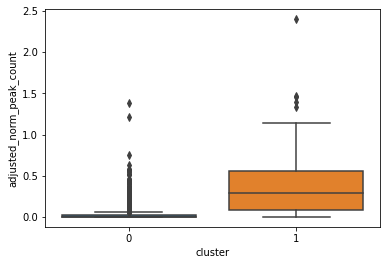

In [17]:
# Check the cluster distribution
sns.boxplot(x="cluster", y='adjusted_norm_peak_count',data=df_kmeans, showfliers = True)

In [18]:
# All method summary
# All linear methods showed similar classification results
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster
import umap
from matplotlib_venn import venn2, venn3

# Read in the data 
# df = pd.read_csv(f"{work_dir}/df_consolidated_ADC_lung_DMR.csv")
df = pd.read_csv(f"{work_dir}/df_consolidated_enhertu_lung_DMR.csv")
pivot_df = df.pivot(index='run_sample_id', columns='region_id', values='adjusted_norm_peak_count')

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Initialize an empty dataframe to collect cluster labels
cluster_results = pd.DataFrame(index=pivot_df.index)

# KMeans++ Clustering
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=0)
cluster_results['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

# Hierarchical Clustering
Z = linkage(scaled_data, method='ward')
cluster_results['hierarchical_cluster'] = fcluster(Z, 2, criterion='maxclust')

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=0)
cluster_results['gmm_cluster'] = gmm.fit_predict(scaled_data)

# PCA + KMeans Clustering
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
kmeans_pca = KMeans(n_clusters=2, random_state=0)
cluster_results['pca_cluster'] = kmeans_pca.fit_predict(pca_data)

# UMAP + KMeans Clustering
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embedding = reducer.fit_transform(scaled_data)
kmeans_umap = KMeans(n_clusters=2, random_state=0)
cluster_results['umap_cluster'] = kmeans_umap.fit_predict(umap_embedding)

# Check the cluster results
cluster_results.head()


,kmeans_cluster,hierarchical_cluster,gmm_cluster,pca_cluster,umap_cluster
run_sample_id,,,,,
A097628801,0,1,0,0,1
A097929201,0,1,0,0,1
A097944901,0,1,0,0,0
A097975601,1,2,1,1,0
A097994401,0,1,0,0,0


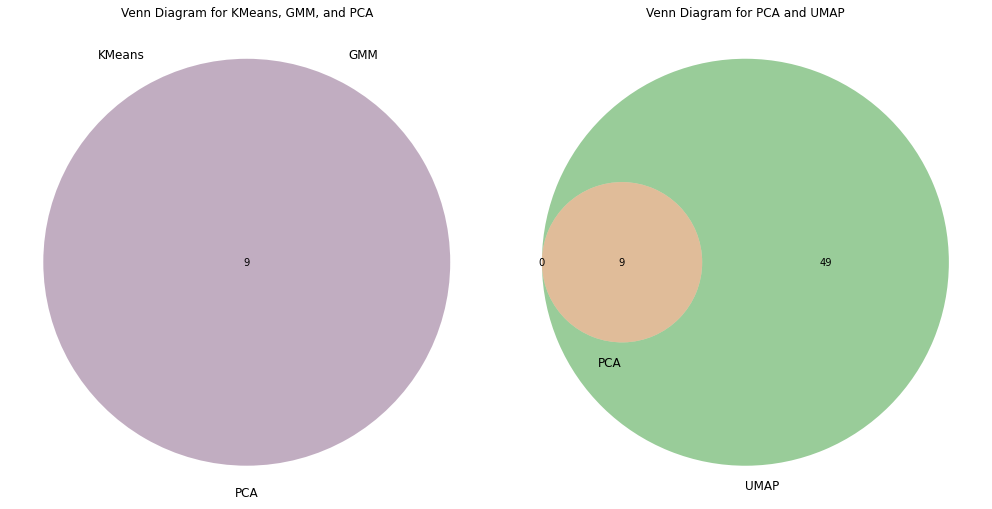

In [20]:
# Check the overlapping condition of all methods 

# Read in the data 
# df = pd.read_csv(f"{work_dir}/df_consolidated_ADC_lung_DMR.csv")
df = pd.read_csv(f"{work_dir}/df_consolidated_enhertu_lung_DMR.csv")
pivot_df = df.pivot(index='run_sample_id', columns='region_id', values='adjusted_norm_peak_count')

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Initialize an empty dataframe to collect cluster labels
cluster_results = pd.DataFrame(index=pivot_df.index)

# KMeans++ Clustering
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=0)
cluster_results['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

# # Hierarchical Clustering (renaming 1,2 to 0,1)
# Z = linkage(scaled_data, method='ward')
# cluster_results['hierarchical_cluster'] = fcluster(Z, 2, criterion='maxclust') - 1  # Subtract 1 to convert from 1,2 to 0,1

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=0)
cluster_results['gmm_cluster'] = gmm.fit_predict(scaled_data)

# PCA + KMeans Clustering
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
kmeans_pca = KMeans(n_clusters=2, random_state=0)
cluster_results['pca_cluster'] = kmeans_pca.fit_predict(pca_data)

# UMAP + KMeans Clustering
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embedding = reducer.fit_transform(scaled_data)
kmeans_umap = KMeans(n_clusters=2, random_state=0)
cluster_results['umap_cluster'] = kmeans_umap.fit_predict(umap_embedding)

# Step 2: Create a set for each cluster assignment (Cluster 0 from all methods for comparison)
kmeans_set = set(cluster_results.index[cluster_results['kmeans_cluster'] == 1])
# hierarchy_set = set(cluster_results.index[cluster_results['hierarchical_cluster'] == 1])
gmm_set = set(cluster_results.index[cluster_results['gmm_cluster'] == 1])
pca_set = set(cluster_results.index[cluster_results['pca_cluster'] == 1])
umap_set = set(cluster_results.index[cluster_results['umap_cluster'] == 0])

# Step 3: Plot Venn Diagrams for pairwise comparison (Complete with 3 methods at a time)
plt.figure(figsize=(14, 7), facecolor='white')
plt.subplot(121)
v = venn3([kmeans_set, gmm_set, pca_set], set_labels=('KMeans', 'GMM', 'PCA'))
for text in v.subset_labels:
    if text:
        text.set_fontsize(10)  # Increase font size
plt.title('Venn Diagram for KMeans, GMM, and PCA')

plt.subplot(122)
v2 = venn2([pca_set, umap_set], set_labels=('PCA', 'UMAP'))
for text in v2.subset_labels:
    if text:
        text.set_fontsize(10)  # Increase font size
plt.title('Venn Diagram for PCA and UMAP')

plt.tight_layout()
plt.show()


In [21]:
# Select the predicted ILD samples by clustering methods (overlapping of all 3 methods)
# Reset the index 
df_cluster_results = cluster_results.reset_index().rename(columns={"index": "run_sample_id"})

# Get the cluster 1 result (high methylation signal group) of all 3 linear clustering algorithm 
df_cluster_results_overlapped = df_cluster_results[(df_cluster_results['kmeans_cluster'] == 1) & (df_cluster_results['gmm_cluster'] == 1) & (df_cluster_results['pca_cluster'] == 1)]

# # Get the cluster 0 result kmeans algorithm 
# df_cluster_results_overlapped = df_cluster_results[(df_cluster_results['kmeans_cluster'] == 0)]

# Save the sample id for cluster 0
High_peak_count_cluster_samples_by_3_cluster_overlap_ids = df_cluster_results_overlapped.run_sample_id.unique()
print(f'The sample size of cluster 1 # is ' + str(len(High_peak_count_cluster_samples_by_3_cluster_overlap_ids)))


The sample size of cluster 1 # is 9


In [22]:
# Read in the data 
# df_consolidated_ADC_lung_DMR_labeled = pd.read_csv(f"{work_dir}/df_consolidated_ADC_lung_DMR.csv")
df_consolidated_enhertu_lung_DMR_labeled = pd.read_csv(f"{work_dir}/df_consolidated_enhertu_lung_DMR.csv")


# Get the label
df_consolidated_enhertu_lung_DMR_labeled['sample_type'] = np.where(df_consolidated_enhertu_lung_DMR_labeled['run_sample_id'].isin(High_peak_count_cluster_samples_by_3_cluster_overlap_ids), 'High_peak_count_cluster', "Low_peak_count_cluster")
print(df_consolidated_enhertu_lung_DMR_labeled.sample_type.value_counts())

# Save the data
df_consolidated_enhertu_lung_DMR_labeled.to_csv(f"{work_dir}/df_consolidated_enhertu_lung_DMR_labeled.csv")
df_consolidated_enhertu_lung_DMR_labeled.head()

Low_peak_count_cluster     1995
High_peak_count_cluster     171
Name: sample_type, dtype: int64


,run_sample_id,runid,analysis_version,region_id,num_molecules,peak_cpg,peak_mol,smooth_ctrl,norm_region_count,norm_peak_count,sample_id,adjusted_log_norm_peak_count,adjusted_norm_peak_count,sample_type
0,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,1_50884795_50885470,9,22,5,2650.40641,0.000076,0.001886,A097628801,-2.722047,0.001896,Low_peak_count_cluster
1,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63281169_63281518,16,22,13,2650.40641,0.000136,0.004905,A097628801,-2.308484,0.004915,Low_peak_count_cluster
2,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63283795_63284040,4,19,4,2622.75911,0.000034,0.001525,A097628801,-2.813860,0.001535,Low_peak_count_cluster
3,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_111875207_111875685,1,13,1,2261.58405,0.000008,0.000442,A097628801,-3.344700,0.000452,Low_peak_count_cluster
4,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,4_57521635_57522882,28,16,9,2517.13333,0.000238,0.003576,A097628801,-2.445450,0.003586,Low_peak_count_cluster


In [ ]:
# Generate the input file for heatmap. This is for the R script LR_adjusted_log_norm_peak_count_screen_clustering_all_linear.R (just need to change the input name and output name)
# IMPORTNAT NOTES: giving the two clusters names based on the all the linear clustering algorithm two groups peak counts. Above plot showed cluster 1 has higher peak counts

df_clustering_for_R_heatmap = df_consolidated_enhertu_lung_DMR_labeled.copy()
df_clustering_for_R_heatmap['sample_type'] = np.where(df_clustering_for_R_heatmap['run_sample_id'].isin(High_peak_count_cluster_samples_by_3_cluster_overlap_ids), 'High_peak_count_cluster', "Low_peak_count_cluster")

# Save the data
df_clustering_for_R_heatmap.to_csv(f"{work_dir}/df_clustering_for_R_heatmap_enhertu_only.csv", index = False)
df_clustering_for_R_heatmap.head()

,run_sample_id,runid,analysis_version,region_id,num_molecules,peak_cpg,peak_mol,smooth_ctrl,norm_region_count,norm_peak_count,sample_id,adjusted_log_norm_peak_count,adjusted_norm_peak_count,sample_type
0,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,1_50884795_50885470,9,22,5,2650.40641,0.000076,0.001886,A097628801,-2.722047,0.001896,Low_peak_count_cluster
1,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63281169_63281518,16,22,13,2650.40641,0.000136,0.004905,A097628801,-2.308484,0.004915,Low_peak_count_cluster
2,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63283795_63284040,4,19,4,2622.75911,0.000034,0.001525,A097628801,-2.813860,0.001535,Low_peak_count_cluster
3,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_111875207_111875685,1,13,1,2261.58405,0.000008,0.000442,A097628801,-3.344700,0.000452,Low_peak_count_cluster
4,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,4_57521635_57522882,28,16,9,2517.13333,0.000238,0.003576,A097628801,-2.445450,0.003586,Low_peak_count_cluster


In [184]:
# df_clustering_for_R_heatmap = pd.read_csv(f"{work_dir}/df_clustering_for_R_heatmap.csv")
df_clustering_for_R_heatmap = pd.read_csv(f"{work_dir}/df_clustering_for_R_heatmap_enhertu_only.csv")

<Axes: xlabel='sample_type', ylabel='adjusted_norm_peak_count'>

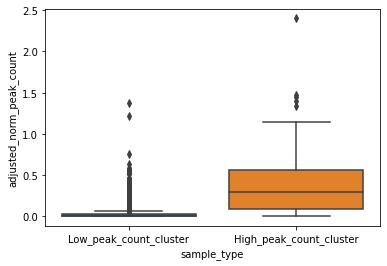

In [24]:
# Check the cluster distribution
sns.boxplot(x="sample_type", y='adjusted_norm_peak_count',data=df_clustering_for_R_heatmap, showfliers = True)

In [196]:
# Merge the treatment information back
df_clustering_for_R_heatmap_all = df_clustering_for_R_heatmap.merge(df_breast_samples_all[['run_sample_id', 'total_yield', 'treatmentnotes', 'treatment', 'ADC_treatment', 'Enhertu_treatment']], on = "run_sample_id", how = "left")
# df_clustering_for_R_heatmap_base = df_clustering_for_R_heatmap_all[df_breast_samples_all['treatment'] == "Non_treatment"]
# df_clustering_for_R_heatmap_treatment = df_clustering_for_R_heatmap_all[df_breast_samples_all['treatment'] == "Treatment"]

df_clustering_for_R_heatmap_treatment = df_clustering_for_R_heatmap_all.copy()
df_clustering_for_R_heatmap_treatment.to_csv(f"{work_dir}/df_clustering_for_R_heatmap_enhertu_treatment_only.csv", index = False)


In [198]:
df_clustering_for_R_heatmap_treatment.region_id.nunique()

19

In [199]:
df_clustering_for_R_heatmap_treatment.run_sample_id.nunique()

132

In [202]:
from statannotations.Annotator import Annotator

def cfDNA_boxplot_by_umap_one_batch_with_annotation(df, suffix_title):
    # Update the y score to cfDNA/ml
    df = df.copy()
    df['cfDNA_ng'] = df['total_yield']

    # Set up the figure with original size and grid style
    fig, ax = plt.subplots(figsize=(18, 15))  # Match the original figure size
    sns.set_style('darkgrid')

    # Order based on the 'sample_type_umap' categories
    hue_order = df['sample_type'].unique().tolist()

    # Define your hue order and use it only when needed. Otherwise commment it out and change back to "palette="Set2""" from "palette=color_map" in the sns.boxplot!!!!!
    # Only use the order for treatment sample plot, use Set2 default for baseline sample plot
    # hue_order = ['Provided Cancer type: breast', 'High_CSO_lung_Samples']
    # hue_order = ['High_peak_count_cluster', 'Low_peak_count_cluster']
    # default_colors = sns.color_palette("Set2", n_colors=len(hue_order))
    # color_map = {cat: col for cat, col in zip(hue_order, default_colors)}

    # Create boxplot and stripplot without using csv_file_name
    sns.boxplot(data=df, x="sample_type", y="cfDNA_ng", showfliers=False, ax=ax, dodge=True, palette="Set2")
    # sns.stripplot(data=df, x="sample_type_umap", y="cfDNA_ng", hue = "treatment", ax=ax, dodge=True, jitter=0.2, size=6)
    sns.stripplot(data=df, x="sample_type", y="cfDNA_ng", hue = "Enhertu_treatment", ax=ax, dodge=True, jitter=0.2, size=6)

    # Log scale for the y-axis
    ax.set_yscale('log')

    # Annotate sample sizes with offset
    # Offset for sample size annotation, adjust as needed
    offset = df['cfDNA_ng'].min() * 0.1  # Adjust the value as needed
    for plot_type, cancer_group in df.groupby('sample_type'):
        n = cancer_group.shape[0]
        type_pos = hue_order.index(plot_type)
        center = ax.get_xticks()[type_pos]  # Center position of each category
        ax.text(center, cancer_group['cfDNA_ng'].min() * 0.9, f'n = {n}', ha='center', va='bottom', fontsize=12, color='black')


    # Setting up the Annotator with the appropriate pairs
    if len(hue_order) > 1:
        pairs = [(hue_order[i], hue_order[j]) for i in range(len(hue_order)) for j in range(i + 1, len(hue_order))]
        annotator = Annotator(ax, pairs, data=df, x="sample_type", y="cfDNA_ng")
        annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2, fontsize=20)
        annotator.apply_and_annotate()

    # # Adjusting the legend to match original settings
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles[:len(hue_order)], labels[:len(hue_order)], title='CSO Lung Sample', loc='upper right', bbox_to_anchor=(1.05, 1))

    # Set plot labels and title to match the original
    plt.title(f'{suffix_title}', fontsize=30)
    ax.set_xlabel('Sample Types', fontsize=25)
    ax.set_ylabel('cfDNA', fontsize=25)
    ax.legend(fontsize=25)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)


    plt.show()



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low_peak_count_cluster vs. High_peak_count_cluster: t-test independent samples, P_val:7.214e-06 t=-4.676e+00


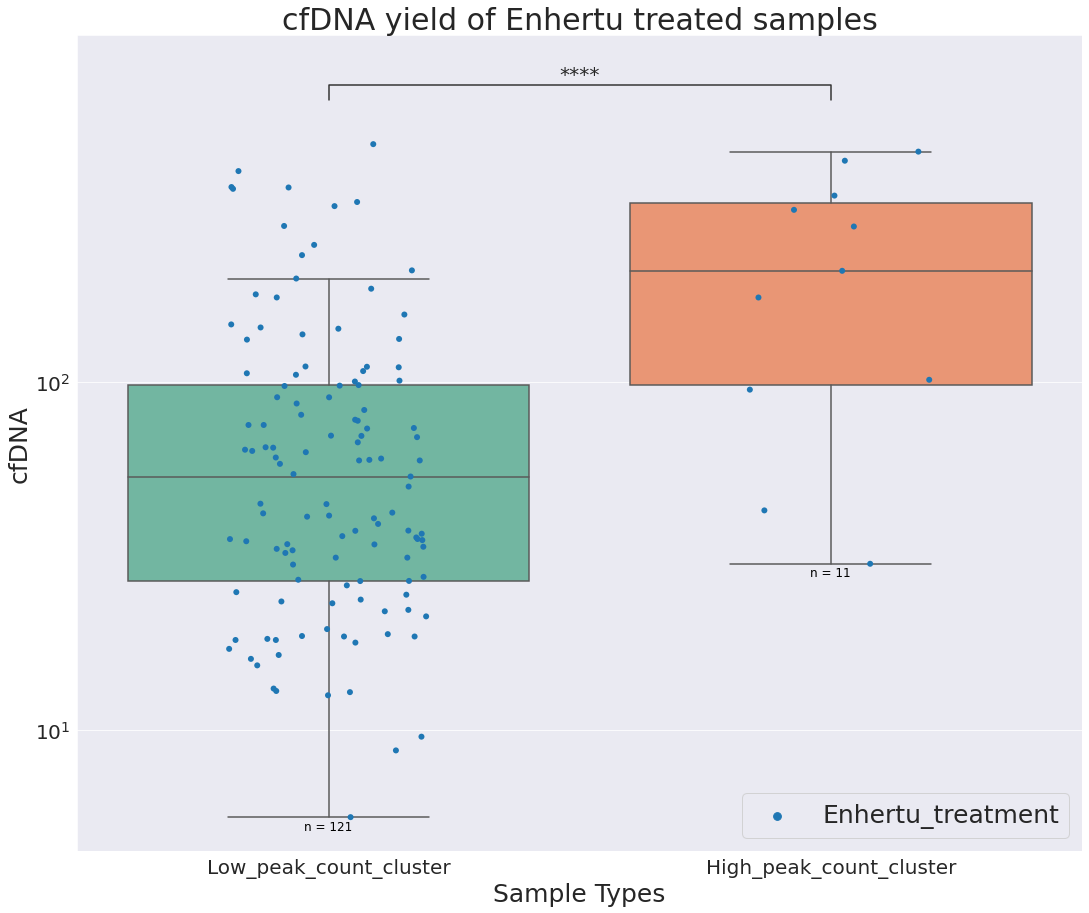

In [203]:
# Check the cfDNA yield 
df_cfDNA_plot = df_clustering_for_R_heatmap_treatment.drop_duplicates(subset = "run_sample_id")

# Dropna
df_cfDNA_plot = df_cfDNA_plot.dropna(subset=['sample_type'])

# plot it
cfDNA_boxplot_by_umap_one_batch_with_annotation(df_cfDNA_plot, 'cfDNA yield of Enhertu treated samples')

## Association between sample level methyl score (LR) vs Region level methyl score (region score)

In [ ]:
# Merge the LR methyl score and LR binary call result back
df_clustering_for_R_heatmap_treatment_with_LR_score = df_clustering_for_R_heatmap_treatment.merge(df_breast_samples_all[['run_sample_id', 'LR_Breast_score', 'LR_Breast_call']], on = 'run_sample_id', how = 'left' )
df_clustering_for_R_heatmap_treatment_with_LR_score.head(20)

,run_sample_id,runid,analysis_version,region_id,num_molecules,peak_cpg,peak_mol,smooth_ctrl,norm_region_count,norm_peak_count,sample_id,adjusted_log_norm_peak_count,adjusted_norm_peak_count,sample_type,total_yield,treatmentnotes,treatment,ADC_treatment,Enhertu_treatment,LR_Breast_score,LR_Breast_call
0,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,1_50884795_50885470,9,22,5,2650.40641,0.000076,0.001886,A097628801,-2.722047,0.001896,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508,Detected
1,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63281169_63281518,16,22,13,2650.40641,0.000136,0.004905,A097628801,-2.308484,0.004915,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508,Detected
2,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63283795_63284040,4,19,4,2622.75911,0.000034,0.001525,A097628801,-2.813860,0.001535,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508,Detected
3,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_111875207_111875685,1,13,1,2261.58405,0.000008,0.000442,A097628801,-3.344700,0.000452,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508,Detected
4,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,4_57521635_57522882,28,16,9,2517.13333,0.000238,0.003576,A097628801,-2.445450,0.003586,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508,Detected
5,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,5_134366914_134367034,10,16,10,2517.13333,0.000085,0.003973,A097628801,-2.399815,0.003983,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508,Detected
6,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,5_134367172_134367292,7,17,7,2565.44725,0.000059,0.002729,A097628801,-2.562476,0.002739,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508,Detected
7,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,6_152622844_152623510,0,0,0,0.00000,0.000000,0.000000,A097628801,-5.000000,0.000010,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508,Detected
8,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,8_72468561_72469244,54,15,21,2452.16124,0.000459,0.008564,A097628801,-2.066823,0.008574,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508,Detected
9,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,8_72469349_72469583,30,17,19,2565.44725,0.000255,0.007406,A097628801,-2.129823,0.007416,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508,Detected


In [ ]:
import scipy.stats

def analyze_and_plot_correlation(df, x_col, y_col, region_col):
    """
    Analyze and plot the correlation between two columns for each unique region.

    Parameters:
    - df: DataFrame containing the data.
    - x_col: The name of the column to be used as the x-axis.
    - y_col: The name of the column to be used as the y-axis.
    - region_col: The name of the column containing region IDs.
    """
    # Get unique regions
    unique_regions = df[region_col].unique()
    
    # Loop through each region and analyze
    for region in unique_regions:
        # Filter the data for the current region
        df_filtered = df[df[region_col] == region]

        # Calculate Pearson and Spearman correlations
        pearson_corr, pearson_p_val = scipy.stats.pearsonr(df_filtered[x_col], df_filtered[y_col])
        spearman_corr, spearman_p_val = scipy.stats.spearmanr(df_filtered[x_col], df_filtered[y_col])

        # Print the correlation results
        print(f"Region: {region}")
        print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {pearson_p_val:.3g}")
        print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {spearman_p_val:.3g}\n")

        # Plotting
        plt.figure(figsize=(8, 6))
        sns.set_style('darkgrid')
        sns.scatterplot(x=x_col, y=y_col, hue = 'LR_Breast_call', data=df_filtered)
        sns.regplot(x=x_col, y=y_col, data=df_filtered, scatter=False, color="gray", line_kws={"linestyle": "--"})

        # Move legend to the bottom right
        plt.legend(title='LR_Breast_call', loc='lower right', bbox_to_anchor=(1, 0))


        plt.title(f"Scatter Plot for Region: {region}")
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.grid(True)

        # Add text annotation for Pearson and Spearman correlation
        plt.text(0.05, 0.95, f'Pearson: r={pearson_corr:.2f}, p={pearson_p_val:.1e}\nSpearman: ρ={spearman_corr:.2f}, p={spearman_p_val:.1e}',
                 ha='left', va='top', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.7))

        plt.tight_layout()
        plt.show()


In [29]:
import scipy.stats
import math

def analyze_and_plot_correlation(df, x_col, y_col, region_col):
    """
    Analyze and plot the correlation between two columns for each unique region in a grid layout.

    Parameters:
    - df: DataFrame containing the data.
    - x_col: The name of the column to be used as the x-axis.
    - y_col: The name of the column to be used as the y-axis.
    - region_col: The name of the column containing region IDs.
    """
    # Get unique regions
    unique_regions = df[region_col].unique()
    num_regions = len(unique_regions)

    # Determine the number of rows and columns for the grid layout
    ncols = 4
    nrows = math.ceil(num_regions / ncols)

    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 4))
    axes = axes.flatten()

    for i, region in enumerate(unique_regions):
        # Filter the data for the current region
        df_filtered = df[df[region_col] == region]

        # Calculate Pearson and Spearman correlations
        pearson_corr, pearson_p_val = scipy.stats.pearsonr(df_filtered[x_col], df_filtered[y_col])
        spearman_corr, spearman_p_val = scipy.stats.spearmanr(df_filtered[x_col], df_filtered[y_col])

        # Plotting
        sns.set_style('darkgrid')
        scatter = sns.scatterplot(ax=axes[i], x=x_col, y=y_col, hue='LR_Breast_call', data=df_filtered)
        sns.regplot(ax=axes[i], x=x_col, y=y_col, data=df_filtered, scatter=False, color="gray", line_kws={"linestyle": "--"})

        # Set title and labels
        axes[i].set_title(f"Region: {region}")
        axes[i].set_xlabel("Region_score")
        axes[i].set_ylabel(y_col)

        # Move legend to the bottom right
        axes[i].legend(title='LR_Breast_call', loc='lower right', bbox_to_anchor=(1, 0))

        # Add text annotation for Pearson and Spearman correlation
        axes[i].text(0.05, 0.95,
                     f'Pearson: r={pearson_corr:.2f}, p={pearson_p_val:.1e}\nSpearman: ρ={spearman_corr:.2f}, p={spearman_p_val:.1e}',
                     ha='left', va='top', transform=axes[i].transAxes, fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.7))

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


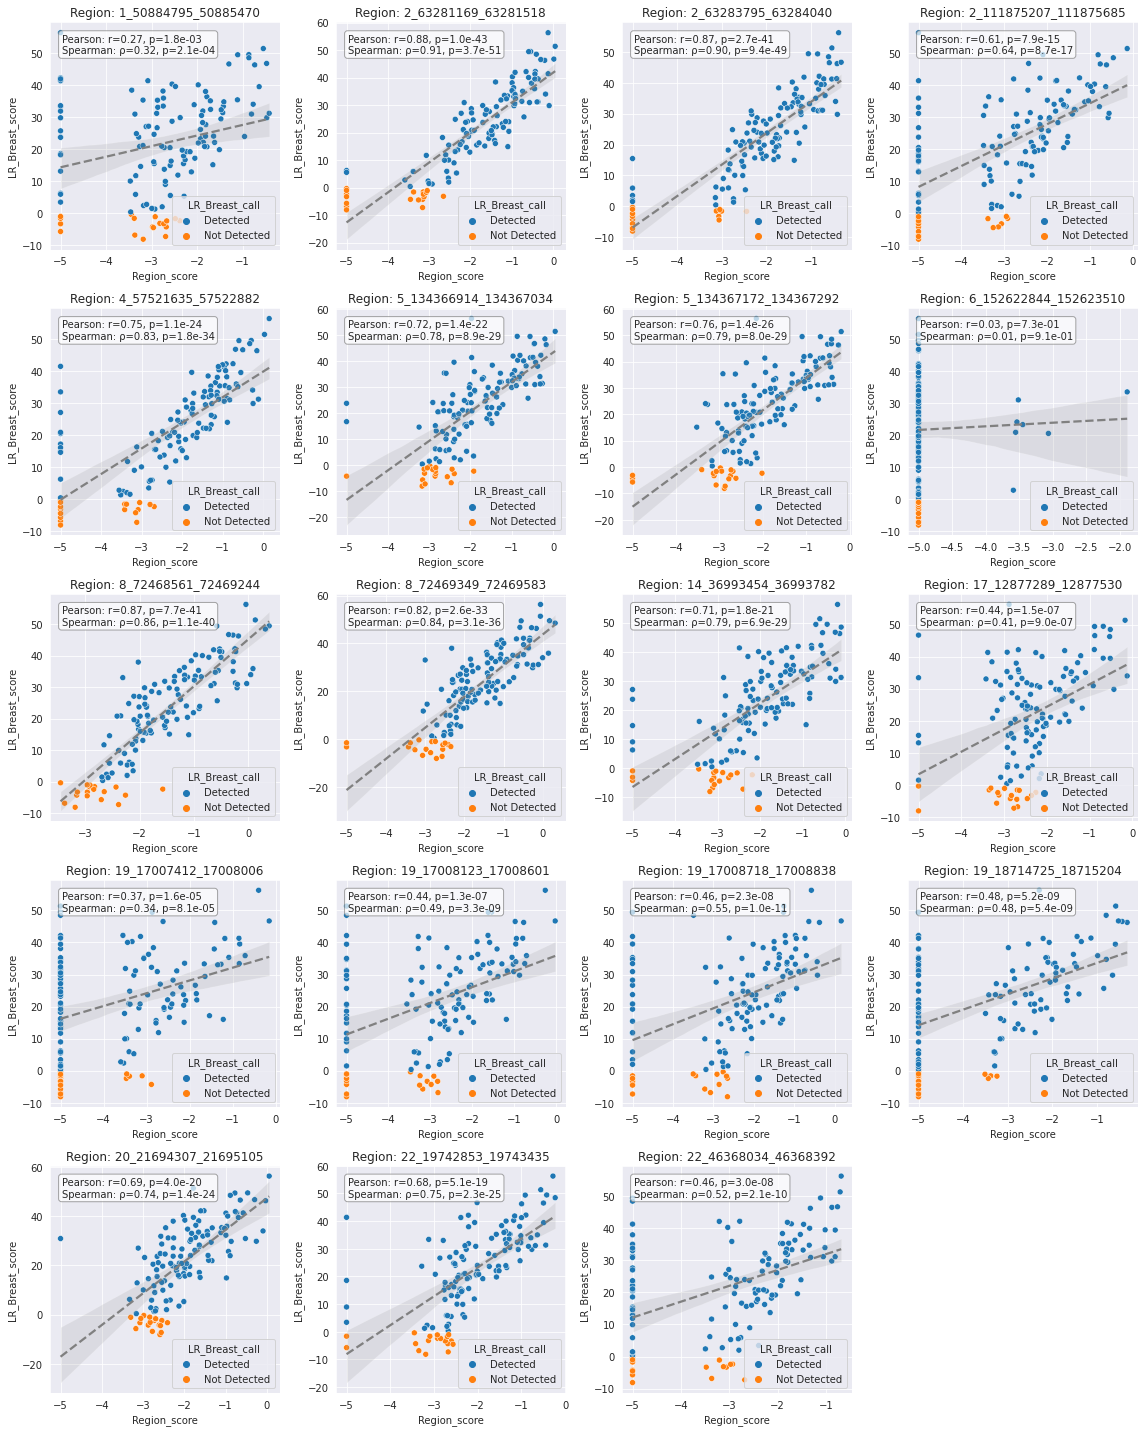

In [30]:
analyze_and_plot_correlation(
    df=df_clustering_for_R_heatmap_treatment_with_LR_score,
    x_col='adjusted_log_norm_peak_count',
    y_col='LR_Breast_score',
    region_col='region_id'
)


In [22]:
df_clustering_for_R_heatmap_treatment_with_LR_score.LR_Breast_score.describe()
#all MB samples (LR+ with reportable somatic variant)
# analyze_and_plot_correlation_MB(df_clustering_for_R_heatmap_treatment_with_LR_score, 'adjusted_log_norm_peak_count', 'LR_Breast_score', exclude_categories=None)

count    2508.000000
mean       21.656693
std        15.399234
min        -8.119320
25%        11.273447
50%        22.662600
75%        33.239243
max        56.284470
Name: LR_Breast_score, dtype: float64

In [10]:
df_clustering_for_R_heatmap_treatment.head()

,run_sample_id,runid,analysis_version,region_id,num_molecules,peak_cpg,peak_mol,smooth_ctrl,norm_region_count,norm_peak_count,sample_id,adjusted_log_norm_peak_count,adjusted_norm_peak_count,sample_type,total_yield,treatmentnotes,treatment,ADC_treatment,Enhertu_treatment
0,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,1_50884795_50885470,9,22,5,2650.40641,0.000076,0.001886,A097628801,-2.722047,0.001896,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment
1,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63281169_63281518,16,22,13,2650.40641,0.000136,0.004905,A097628801,-2.308484,0.004915,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment
2,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63283795_63284040,4,19,4,2622.75911,0.000034,0.001525,A097628801,-2.813860,0.001535,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment
3,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_111875207_111875685,1,13,1,2261.58405,0.000008,0.000442,A097628801,-3.344700,0.000452,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment
4,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,4_57521635_57522882,28,16,9,2517.13333,0.000238,0.003576,A097628801,-2.445450,0.003586,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment


# ILD model

## Data processing

In [2]:
# Readin the training data
df_clustering_for_R_heatmap_treatment = pd.read_csv(f"{work_dir}/df_clustering_for_R_heatmap_enhertu_treatment_only.csv")
print("Total size of sample is " + str(df_clustering_for_R_heatmap_treatment.run_sample_id.nunique()) + "\n") 
print("Total size of region is " + str(df_clustering_for_R_heatmap_treatment.region_id.nunique()) + "\n")

# Readin the test data (no label)
treatment_effect_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/Treatement_Effect_RUOMRD_CSO_call_05052024"

# # Readin DSI SOW21 MB Breast Neg treatment samples with predicted label by 18 DMRs
# df_consolidated_LR_DMR_DSI21_MBneg_treat_18_with_label = pd.read_csv(f"{treatment_effect_dir}/df_clustering_for_R_heatmap_treatment.csv")
# print("Total size of sample is " + str(df_consolidated_LR_DMR_DSI21_MBneg_treat_18_with_label.run_sample_id.nunique()) + "\n") 
# print("Total size of region is " + str(df_consolidated_LR_DMR_DSI21_MBneg_treat_18_with_label.region_id.nunique()) + "\n") 

# Readin DSI SOW21 MB Breast Neg treatment samples by 19 DMRs
df_consolidated_LR_DMR_DSI21_MBneg_treat_19 = pd.read_csv(f"{treatment_effect_dir}/df_consolidated_sub4_LR_DMR_lung_tissue_specific_treatment_19.csv")
print("Total size of sample is " + str(df_consolidated_LR_DMR_DSI21_MBneg_treat_19.run_sample_id.nunique()) + "\n") 
print("Total size of region is " + str(df_consolidated_LR_DMR_DSI21_MBneg_treat_19.region_id.nunique()) + "\n")


df_clustering_for_R_heatmap_treatment.head()

Total size of sample is 132

Total size of region is 19

Total size of sample is 102

Total size of region is 19



,run_sample_id,runid,analysis_version,region_id,num_molecules,peak_cpg,peak_mol,smooth_ctrl,norm_region_count,norm_peak_count,sample_id,adjusted_log_norm_peak_count,adjusted_norm_peak_count,sample_type,total_yield,treatmentnotes,treatment,ADC_treatment,Enhertu_treatment
0,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,1_50884795_50885470,9,22,5,2650.40641,0.000076,0.001886,A097628801,-2.722047,0.001896,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment
1,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63281169_63281518,16,22,13,2650.40641,0.000136,0.004905,A097628801,-2.308484,0.004915,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment
2,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63283795_63284040,4,19,4,2622.75911,0.000034,0.001525,A097628801,-2.813860,0.001535,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment
3,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_111875207_111875685,1,13,1,2261.58405,0.000008,0.000442,A097628801,-3.344700,0.000452,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment
4,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,4_57521635_57522882,28,16,9,2517.13333,0.000238,0.003576,A097628801,-2.445450,0.003586,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment


In [3]:
# Introduce sample-level methyl score as a feature as well
# Readin the data
df_breast_samples_all = pd.read_csv(f"{work_dir}/df_breast_samples_all.csv")

df_clustering_for_R_heatmap_treatment_with_LR_methyl_score = df_clustering_for_R_heatmap_treatment.merge(df_breast_samples_all[['run_sample_id', 'LR_Breast_score']], on = 'run_sample_id', how = "left")
df_clustering_for_R_heatmap_treatment_with_LR_methyl_score.head()

,run_sample_id,runid,analysis_version,region_id,num_molecules,peak_cpg,peak_mol,smooth_ctrl,norm_region_count,norm_peak_count,sample_id,adjusted_log_norm_peak_count,adjusted_norm_peak_count,sample_type,total_yield,treatmentnotes,treatment,ADC_treatment,Enhertu_treatment,LR_Breast_score
0,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,1_50884795_50885470,9,22,5,2650.40641,0.000076,0.001886,A097628801,-2.722047,0.001896,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508
1,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63281169_63281518,16,22,13,2650.40641,0.000136,0.004905,A097628801,-2.308484,0.004915,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508
2,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_63283795_63284040,4,19,4,2622.75911,0.000034,0.001525,A097628801,-2.813860,0.001535,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508
3,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,2_111875207_111875685,1,13,1,2261.58405,0.000008,0.000442,A097628801,-3.344700,0.000452,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508
4,A097628801,240301_A01112_0467_AHTGFYDSX7,Sirius-1.1.2-RLS,4_57521635_57522882,28,16,9,2517.13333,0.000238,0.003576,A097628801,-2.445450,0.003586,Low_peak_count_cluster,63.44,Enhertu,Treatment,ADC_treatment,Enhertu_treatment,13.70508


In [4]:
# Reformat the traning data
df_train = df_clustering_for_R_heatmap_treatment.copy()
df_train = df_train[['run_sample_id', 'region_id', 'adjusted_log_norm_peak_count', 'sample_type']]

# Pivot the data to make region_id as columns
df_pivot = df_train.pivot(index='run_sample_id', columns='region_id', values='adjusted_log_norm_peak_count')

# Add the target variable (y-label) back to the reshaped dataframe
df_pivot['sample_type'] = df_train.groupby('run_sample_id')['sample_type'].first()

# Rename the label
df_pivot['sample_type'] = np.where(df_pivot['sample_type'] == "Low_peak_count_cluster", "ILD_Negative", "ILD_Positive")

# Reset the index for a cleaner dataframe
df_train = df_pivot.reset_index()
print(df_train.shape)
print(df_train.sample_type.value_counts())
df_train.head()

# Add sample-level methyl score as a feature
df_train_with_methyl_score = df_train.merge(df_clustering_for_R_heatmap_treatment_with_LR_methyl_score[['run_sample_id', 'LR_Breast_score']], on = 'run_sample_id', how = 'left')

# Save the training data
df_train.to_csv(f"{work_dir}/df_train.csv", index = False)


(132, 21)
ILD_Negative    121
ILD_Positive     11
Name: sample_type, dtype: int64


In [5]:
# Reformat the test data
df_test = df_consolidated_LR_DMR_DSI21_MBneg_treat_19.copy()
df_test = df_test[['run_sample_id', 'region_id', 'adjusted_log_norm_peak_count', 'sample_type']]

# Pivot the data to make region_id as columns
df_pivot = df_test.pivot(index='run_sample_id', columns='region_id', values='adjusted_log_norm_peak_count')

# Add the target variable (y-label) back to the reshaped dataframe
df_pivot['sample_type'] = df_test.groupby('run_sample_id')['sample_type'].first()

# Rename the label
df_pivot['sample_type'] = np.where(df_pivot['sample_type'] == "Low_peak_count_cluster", "ILD_Negative", "ILD_Positive")

# Reset the index for a cleaner dataframe
df_test = df_pivot.reset_index()
print(df_test.shape)
print(df_test.sample_type.value_counts())
df_test.head()

# Save the training data
df_test.to_csv(f"{work_dir}/df_test.csv", index = False)
df_test.head()


(102, 21)
ILD_Positive    102
Name: sample_type, dtype: int64


region_id,run_sample_id,14_36993454_36993782,17_12877289_12877530,19_17007412_17008006,19_17008123_17008601,19_17008718_17008838,19_18714725_18715204,1_50884795_50885470,20_21694307_21695105,22_19742853_19743435,22_46368034_46368392,2_111875207_111875685,2_63281169_63281518,2_63283795_63284040,4_57521635_57522882,5_134366914_134367034,5_134367172_134367292,6_152622844_152623510,8_72468561_72469244,8_72469349_72469583,sample_type
0,B00460895,-5.000000,-2.156596,-5.000000,-2.879508,-2.578029,-5.0,-2.954920,-2.377362,-5.000000,-5.000000,-2.637895,-2.632430,-3.158333,-5.0,-2.852416,-2.819837,-5.0,-2.552937,-3.150367,ILD_Positive
1,B00460897,-5.000000,-2.103536,-2.407411,-5.000000,-5.000000,-5.0,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-2.382604,-5.0,-1.943946,-2.370478,-5.0,-2.392451,-5.000000,ILD_Positive
2,B00460904,-2.925465,-5.000000,-3.265819,-5.000000,-3.291016,-5.0,-3.235635,-2.771543,-2.405035,-5.000000,-5.000000,-5.000000,-5.000000,-5.0,-2.769845,-2.757357,-5.0,-2.946353,-2.938231,ILD_Positive
3,B00460910,-2.791344,-5.000000,-5.000000,-5.000000,-5.000000,-5.0,-5.000000,-2.665713,-2.796643,-2.788250,-5.000000,-2.789952,-5.000000,-5.0,-2.766164,-2.792789,-5.0,-2.481884,-5.000000,ILD_Positive
4,B00460939,-2.971966,-5.000000,-5.000000,-3.041425,-3.041425,-5.0,-5.000000,-2.997989,-2.990328,-2.984184,-2.986156,-5.000000,-5.000000,-5.0,-2.672976,-2.986156,-5.0,-2.994729,-2.691427,ILD_Positive


In [6]:
# # Handle the missing values in region_id
df_train_1 = df_train.copy()
df_train_1 = df_train_with_methyl_score.copy()

# # Method 1: Imputation with Median
# df_train_1 = df_train.copy()
# df_train_1.fillna(df_train_1.median(), inplace=True)
# df_train_1.head()

# # Method 2: KNN Imputation
# from sklearn.impute import KNNImputer
# df_train_1 = df_train.copy()
# # Initialize the KNNImputer (arbitrary choice)
# imputer = KNNImputer(n_neighbors=3)

# # Apply KNNImputer to the numeric columns 
# imputed_array = imputer.fit_transform(df_train_1.iloc[:, 1:-1])

# # Convert the result back to a DataFrame, keeping the same column names
# df_train_1 = pd.DataFrame(imputed_array, columns=df_train_1.columns[1:-1])
# df_train_1.head()

In [ ]:
# import numpy as np
# from sklearn.impute import KNNImputer
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier

# # Define the range of n_neighbors to test
# neighbor_values = [3, 5, 7, 10]

# # Prepare data
# X = df_train.iloc[:, 1:-1]  # Features
# y = df_train['sample_type']  # Labels

# # Results dictionary to store model performance for each n_neighbors
# results = {}

# for n in neighbor_values:
#     # Apply KNN imputation
#     imputer = KNNImputer(n_neighbors=n)
#     X_imputed = imputer.fit_transform(X)
    
#     # Train a model (e.g., Random Forest) and evaluate using cross-validation
#     model = RandomForestClassifier(random_state=42)
#     scores = cross_val_score(model, X_imputed, y, cv=5, scoring='accuracy')
#     results[n] = np.mean(scores)

# # Display results
# for n, score in results.items():
#     print(f"n_neighbors = {n}, Accuracy = {score:.4f}")


## Model Training (Quick try)

### Split dataset

In [43]:
# Feature splitting
# Get ground truth data 
y = np.where(df_train_1['sample_type'] == "ILD_Negative" ,0,1)
X = df_train_1.drop(['run_sample_id', 'sample_type'], axis=1)

In [44]:
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 105 observation with 19 features
test data has 27 observation with 19 features


In [ ]:
# Under sampling

# from imblearn.under_sampling import RandomUnderSampler
# from sklearn import model_selection


# RandomUnderSampler = RandomUnderSampler()
# X_resampled, y_resampled = RandomUnderSampler.fit_sample(X, y)

# # Reserve 20% for testing
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X_resampled, y_resampled, test_size=0.2)
# print('training data has %d observation with %d features'% X_train.shape)
# print('test data has %d observation with %d features'% X_test.shape)

In [45]:
# Standarized the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
#title build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
# Logistic Regression
classifier_logistic = LogisticRegression(random_state=42)

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# SVM
classifier_SVC = SVC(random_state=42)

# Random Forest
classifier_RF = RandomForestClassifier(random_state=42)

# XGB
classifier_XGB = XGBClassifier(random_state=42)


In [47]:
# LR model accuracy performance quick check
classifier_logistic.fit(X_train, y_train)
y_pred = classifier_logistic.predict(X_test)
classifier_logistic.score(X_test, y_test)

0.9259259259259259

In [48]:
# K-Fold Cross-Validation
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [49]:
# Use 10-fold Cross Validation to get the accuracy for different models
# model_names = ['Logistic Regression','KNN','Random Forest','SVM', 'XGBoost']
model_names = ['Logistic Regression','KNN','Random Forest','SVM']

# model_list = [classifier_logistic, classifier_KNN, classifier_RF, classifier_SVC, classifier_XGB]
model_list = [classifier_logistic, classifier_KNN, classifier_RF, classifier_SVC]

count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=cv)
    # print(cv_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
    count += 1

Model accuracy of Logistic Regression is: 0.972
Model accuracy of KNN is: 0.935
Model accuracy of Random Forest is: 0.990
Model accuracy of SVM is: 0.963


In [50]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Explore for the fold choice
results_5fold = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5, scoring='accuracy')
results_10fold = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=10, scoring='accuracy')

print(f"5-Fold CV Accuracy: Mean = {results_5fold.mean():.4f}, Std = {results_5fold.std():.4f}")
print(f"10-Fold CV Accuracy: Mean = {results_10fold.mean():.4f}, Std = {results_10fold.std():.4f}")


5-Fold CV Accuracy: Mean = 1.0000, Std = 0.0000
10-Fold CV Accuracy: Mean = 1.0000, Std = 0.0000


### Model Training and Selection

#### Use Grid Search to Find Optimal Hyperparameters

In [219]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

#### Find Optimal Hyperparameters: LinearRegression

In [220]:
# Possible hyperparamter options for Logistic Regression Regularization
parameters = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),  # Search on a log scale
    'solver': ['liblinear']  # 'liblinear' supports both l1 and l2 penalties
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=10)
Grid_LR.fit(X_train, y_train)
print_grid_search_metrics(Grid_LR)
best_LR_model = Grid_LR.best_estimator_

Best score: 0.981
Best parameters set:
	C: 1.0
	penalty: 'l1'
	solver: 'liblinear'


In [105]:
# Possible hyperparamter options for Random Forest--choose the best number of trees
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=10)
Grid_RF.fit(X_train, y_train)
print_grid_search_metrics(Grid_RF)
best_RF_model = Grid_RF.best_estimator_

Best score: 0.963
Best parameters set:
	max_depth: None
	min_samples_leaf: 1
	min_samples_split: 10
	n_estimators: 100


In [104]:
# Possible hyperparamter options for KNN --choose the best k
parameters = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (p=1) and Euclidean (p=2) distances
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=10)
Grid_KNN.fit(X_train, y_train)
print_grid_search_metrics(Grid_KNN)
best_KNN_model = Grid_KNN.best_estimator_

Best score: 0.925
Best parameters set:
	n_neighbors: 3
	p: 1
	weights: 'uniform'


In [ ]:
# Possible hyperparamter options for XGBoost 
parameters = {
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

Grid_XGB = GridSearchCV(classifier_XGB,parameters, cv=10)
Grid_XGB.fit(X_train, y_train)
print_grid_search_metrics(Grid_XGB)
best_XGB_model = Grid_XGB.best_estimator_

### Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

#### Evaluate all models

In [221]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate and print a detailed classification report
y_pred = best_RF_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["ILD_Negative", "ILD_Positive"]))

# Compute and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

ILD_Negative       0.89      1.00      0.94        24
ILD_Positive       0.00      0.00      0.00         3

    accuracy                           0.89        27
   macro avg       0.44      0.50      0.47        27
weighted avg       0.79      0.89      0.84        27

Confusion Matrix:
[[24  0]
 [ 3  0]]


In [222]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Example for Random Forest
y_pred_proba = best_RF_model.predict_proba(X_test)[:, 1]
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba)
}
print(metrics)


{'Accuracy': 0.8888888888888888, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.9305555555555556}


In [223]:
# pip install mlxtend


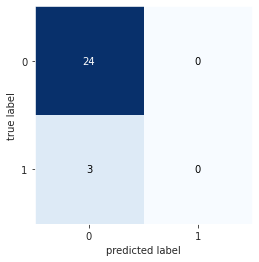

In [224]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Plot confusion matrix
cm = confusion_matrix(y_target=y_test, y_predicted=y_pred, binary=True)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()


### Model Evaluation - ROC & AUC

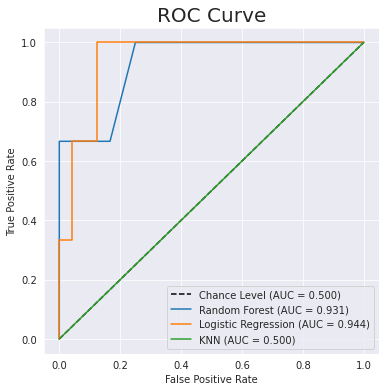

Random Forest AUC: 0.931
Logistic Regression AUC: 0.944
KNN AUC: 0.500


In [228]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate ROC and AUC for multiple models
def plot_roc_auc(models, X_test, y_test):
    """
    Plots the ROC curves and calculates AUC for multiple models.
    
    Parameters:
        models (dict): Dictionary of models with keys as model names and values as trained model objects.
        X_test (ndarray): Test features.
        y_test (ndarray): Test labels.
        
    Returns:
        None
    """
    plt.figure(figsize=(6, 6))
    sns.set_style('darkgrid')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.500)')
    
    auc_scores = {}
    
    for model_name, model in models.items():
        # Predict probabilities and calculate ROC
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)
        auc_scores[model_name] = auc_score
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve', fontsize=20)
    plt.legend(loc='best', fontsize=10)
    plt.show()
    
    # Print AUC scores
    for model_name, auc_score in auc_scores.items():
        print(f'{model_name} AUC: {auc_score:.3f}')



# Run the function
models = {
    'Random Forest': best_RF_model,
    'Logistic Regression': best_LR_model,
    'KNN': best_KNN_model,
    # Uncomment if XGBoost is used
    # 'XGBoost': best_XGB_model
}

plot_roc_auc(models, X_test, y_test)


## Model training (all merged)

### LR: The tuning of the best threshold is using the Geometric Mean.


Summary of Results:
Overall AUC: 0.9949
AUC (Mean, Std): 1.0 0.0
AUC (CI): (1.0, 1.0, 1.0)
Mean G-Mean Threshold: 0.6619939228921161
Threshold Range: 0.5650916988891163 - 0.9013888875989856
Accuracy (Mean, Std): 1.0 0.0
Precision (Mean, Std): 1.0 0.0
Recall (Mean, Std): 1.0 0.0
F1 Score (Mean, Std): 1.0 0.0
PPV (Mean, Std): 1.0 0.0
NPV (Mean, Std): 1.0 0.0
Sensitivity (Mean, Std): 1.0 0.0
Specificity (Mean, Std): 1.0 0.0


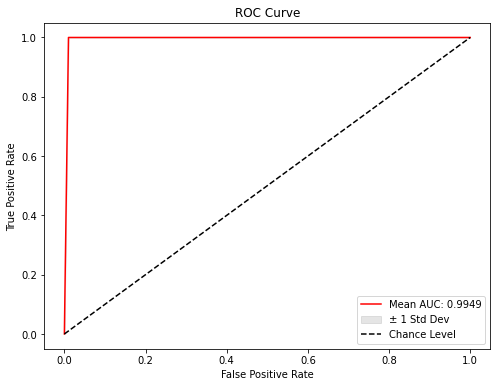

In [17]:
### LR: ShuffleSplit to do "cross validation" 100 interation with 80/20 train/test split. The tuning of the best threshold is using the Geometric Mean.

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt, argmax
import scipy.stats

# Set seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)

set_seed(42)

# Confidence interval calculation
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# Function to calculate PPV, NPV, Sensitivity, and Specificity
def calculate_additional_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    PPV = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision for Positive class
    NPV = tn / (tn + fn) if (tn + fn) > 0 else 0  # Precision for Negative class
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for Positive class
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for Negative class
    return PPV, NPV, sensitivity, specificity

# Prepare data
y = np.where(df_train_1['sample_type'] == "ILD_Negative", 0, 1)
X = df_train_1.drop(['run_sample_id', 'sample_type'], axis=1)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize StratifiedShuffleSplit for balanced splits
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# Logistic Regression Grid Parameters
parameters = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100]}

# Initialize metric storage
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = [], []
accuracys, precisions, recalls, f1_scores = [], [], [], []
PPVs, NPVs, sensitivities, specificities = [], [], [], []
thresholds_used = []  # Store the G-Mean thresholds

# Cross-validation loop
for fold_idx, (train_index, test_index) in enumerate(sss.split(X, y)):
    # Standrization split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    # y_train, y_test = y[train_index], y[test_index]

    
    # Grid search for Logistic Regression
    Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42), parameters, cv=10)
    Grid_LR.fit(X_train, y_train)
    best_LR_model = Grid_LR.best_estimator_
    
    # Predict probabilities and compute ROC
    pred_proba = best_LR_model.predict_proba(X_test)[:, 1]
    fpr_fold, tpr_fold, thresholds = roc_curve(y_test, pred_proba)
    auc_score = auc(fpr_fold, tpr_fold)
    aucs.append(auc_score)
    
    # Interpolate TPR
    interp_tpr = np.interp(mean_fpr, fpr_fold, tpr_fold)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    # Compute G-Mean and best threshold
    gmeans = sqrt(tpr_fold * (1 - fpr_fold))
    ix = argmax(gmeans)
    best_thr = thresholds[ix]
    thresholds_used.append(best_thr)
    
    # Classify based on the G-Mean threshold
    y_pred_best_thr = (pred_proba >= best_thr).astype(int)
    
    # Evaluate metrics
    accuracys.append(accuracy_score(y_test, y_pred_best_thr))
    precisions.append(precision_score(y_test, y_pred_best_thr))
    recalls.append(recall_score(y_test, y_pred_best_thr))
    f1_scores.append(f1_score(y_test, y_pred_best_thr))
    
    # Confusion Matrix and Additional Metrics
    cm = confusion_matrix(y_test, y_pred_best_thr)
    PPV, NPV, sensitivity, specificity = calculate_additional_metrics(cm)
    PPVs.append(PPV)
    NPVs.append(NPV)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Calculate and display overall metrics
mean_auc = auc(mean_fpr, np.mean(tprs, axis=0))
print("\nSummary of Results:")
print(f"Overall AUC: {mean_auc:.4f}")
print("AUC (Mean, Std):", np.round(np.mean(aucs), 4), np.round(np.std(aucs), 4))
print("AUC (CI):", mean_confidence_interval(aucs))
print("Mean G-Mean Threshold:", np.mean(thresholds_used))
print("Threshold Range:", np.min(thresholds_used), "-", np.max(thresholds_used))
print("Accuracy (Mean, Std):", np.round(np.mean(accuracys), 4), np.round(np.std(accuracys), 4))
print("Precision (Mean, Std):", np.round(np.mean(precisions), 4), np.round(np.std(precisions), 4))
print("Recall (Mean, Std):", np.round(np.mean(recalls), 4), np.round(np.std(recalls), 4))
print("F1 Score (Mean, Std):", np.round(np.mean(f1_scores), 4), np.round(np.std(f1_scores), 4))
print("PPV (Mean, Std):", np.round(np.mean(PPVs), 4), np.round(np.std(PPVs), 4))
print("NPV (Mean, Std):", np.round(np.mean(NPVs), 4), np.round(np.std(NPVs), 4))
print("Sensitivity (Mean, Std):", np.round(np.mean(sensitivities), 4), np.round(np.std(sensitivities), 4))
print("Specificity (Mean, Std):", np.round(np.mean(specificities), 4), np.round(np.std(specificities), 4))

# Plot ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='red', label=f"Mean AUC: {mean_auc:.4f}")
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label="± 1 Std Dev")
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='best')
plt.show()

### LR Feature importance analysis 

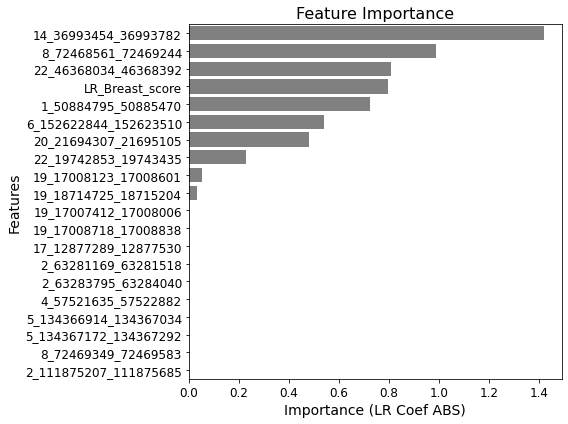

In [18]:
# Get feature importance from the Logistic Regression model
feature_names = df_train_1.drop(['run_sample_id', 'sample_type'], axis=1).columns  # Feature names from your dataset
coefficients = best_LR_model.coef_[0]  # Coefficients from the best LR model

# Create a dataframe for feature importance
df_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)  # Absolute values for ranking
}).sort_values(by='Importance', ascending=False)

# # Optional: Filter for meaningful importance values (e.g., > 0.02)
# df_feature_importance = df_feature_importance[df_feature_importance['Importance'] > 0.02]

# Plot the feature importance
plt.figure(figsize=(8, 6))
sns.barplot(y='Feature', x='Importance', data=df_feature_importance, color='gray')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance (LR Coef ABS)', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


### LR: The tuning of the best threshold for Sensitivity ≥ 90% or Specificity ≥ 90%.

Thresholds used for sensitivity >= 90% in each fold:
Mean threshold: 0.7783
Threshold range: 0.7267 - 0.8994
Overall AUC: 0.9949
AUC (Mean, Std): 1.0 0.0
AUC (CI): (1.0, 1.0, 1.0)
Accuracy (Mean, Std): 0.9966 0.0036
Precision (Mean, Std): 1.0 0.0
Recall (Mean, Std): 0.959 0.0431
F1 Score (Mean, Std): 0.9786 0.0226
PPV (Mean, Std): 1.0 0.0
NPV (Mean, Std): 0.9963 0.0039
Sensitivity (Mean, Std): 0.959 0.0431
Specificity (Mean, Std): 1.0 0.0


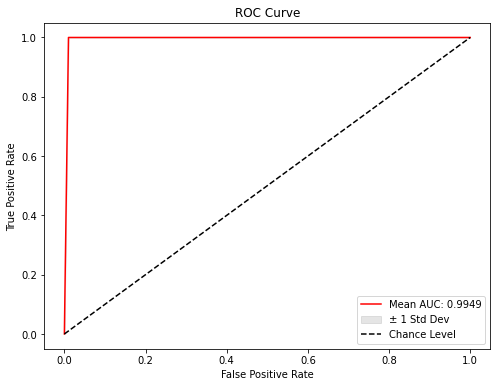

In [16]:
### LR: ShuffleSplit to do "cross validation" 100 interation with 80/20 train/test split. 

# Sensitivity Threshold: The code adjusts the decision threshold dynamically to ensure sensitivity >= 90%.
# Validation for ROC Curve: Skips folds with invalid ROC inputs (e.g., single-class test sets).

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Set seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)

set_seed(42)

# Confidence interval calculation
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# Function to calculate PPV, NPV, Sensitivity, and Specificity
def calculate_additional_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    PPV = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision for Positive class
    NPV = tn / (tn + fn) if (tn + fn) > 0 else 0  # Precision for Negative class
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for Positive class
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for Negative class
    return PPV, NPV, sensitivity, specificity

# Prepare data
y = np.where(df_train_1['sample_type'] == "ILD_Negative", 0, 1)
X = df_train_1.drop(['run_sample_id', 'sample_type'], axis=1)

# # Standardize features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Initialize StratifiedShuffleSplit for balanced splits
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# Logistic Regression Grid Parameters
parameters = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100]}

# Initialize metric storage
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = [], []
accuracys, precisions, recalls, f1_scores = [], [], [], []
PPVs, NPVs, sensitivities, specificities = [], [], [], []

# Initialize storage for thresholds
thresholds_used = []

# Cross-validation loop
for train_index, test_index in sss.split(X, y):
    # Standrization split
    # X_train, X_test = X[train_index], X[test_index]
    # y_train, y_test = y[train_index], y[test_index]

    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y[train_index], y[test_index]

    
    # Grid search for Logistic Regression
    Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42), parameters, cv=10)
    Grid_LR.fit(X_train, y_train)
    best_LR_model = Grid_LR.best_estimator_
    
    # Predict probabilities
    pred_proba = best_LR_model.predict_proba(X_test)[:, 1]
    
    # Check for valid ROC computation
    if len(np.unique(y_test)) < 2:
        print(f"Skipping fold due to single class in y_test: {np.unique(y_test)}")
        continue
    
    # Compute ROC
    fpr_fold, tpr_fold, thresholds = roc_curve(y_test, pred_proba)
    
    # Find threshold for sensitivity >= 90%
    best_thr = thresholds[0]  # Default to the first threshold if no valid one is found
    for fold_threshold in thresholds:
        tp = ((pred_proba >= fold_threshold) & (y_test == 1)).sum()
        fn = ((pred_proba < fold_threshold) & (y_test == 1)).sum()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        if sensitivity >= 0.90:
            best_thr = fold_threshold
            break

    # # Find threshold for specificity >= 95%
    # best_thr = thresholds[0]  # Default to the first threshold if no valid one is found
    # for fold_threshold in thresholds:
    #     tn = ((pred_proba < fold_threshold) & (y_test == 0)).sum()
    #     fp = ((pred_proba >= fold_threshold) & (y_test == 0)).sum()
    #     specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    #     if specificity >= 0.9:
    #         best_thr = fold_threshold
    #         break
    
    # Store the threshold used
    thresholds_used.append(best_thr)
    
    # Classify based on the selected threshold
    y_pred_best_thr = (pred_proba >= best_thr).astype(int)
    
    # Evaluate metrics
    auc_score = auc(fpr_fold, tpr_fold)
    aucs.append(auc_score)
    cm = confusion_matrix(y_test, y_pred_best_thr)
    PPV, NPV, sensitivity, specificity = calculate_additional_metrics(cm)
    PPVs.append(PPV)
    NPVs.append(NPV)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    accuracys.append(accuracy_score(y_test, y_pred_best_thr))
    precisions.append(precision_score(y_test, y_pred_best_thr))
    recalls.append(recall_score(y_test, y_pred_best_thr))
    f1_scores.append(f1_score(y_test, y_pred_best_thr))

    # Interpolate TPR
    interp_tpr = np.interp(mean_fpr, fpr_fold, tpr_fold)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

# Print the thresholds used
print("Thresholds used for sensitivity >= 90% in each fold:")
# print(thresholds_used)
print(f"Mean threshold: {np.mean(thresholds_used):.4f}")
print(f"Threshold range: {min(thresholds_used):.4f} - {max(thresholds_used):.4f}")

# Calculate and display overall metrics
mean_auc = auc(mean_fpr, np.mean(tprs, axis=0))
print(f"Overall AUC: {mean_auc:.4f}")
print("AUC (Mean, Std):", np.round(np.mean(aucs), 4), np.round(np.std(aucs), 4))
print("AUC (CI):", mean_confidence_interval(aucs))
print("Accuracy (Mean, Std):", np.round(np.mean(accuracys), 4), np.round(np.std(accuracys), 4))
print("Precision (Mean, Std):", np.round(np.mean(precisions), 4), np.round(np.std(precisions), 4))
print("Recall (Mean, Std):", np.round(np.mean(recalls), 4), np.round(np.std(recalls), 4))
print("F1 Score (Mean, Std):", np.round(np.mean(f1_scores), 4), np.round(np.std(f1_scores), 4))
print("PPV (Mean, Std):", np.round(np.mean(PPVs), 4), np.round(np.std(PPVs), 4))
print("NPV (Mean, Std):", np.round(np.mean(NPVs), 4), np.round(np.std(NPVs), 4))
print("Sensitivity (Mean, Std):", np.round(np.mean(sensitivities), 4), np.round(np.std(sensitivities), 4))
print("Specificity (Mean, Std):", np.round(np.mean(specificities), 4), np.round(np.std(specificities), 4))

# Plot ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='red', label=f"Mean AUC: {mean_auc:.4f}")
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label="± 1 Std Dev")
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import (
#     roc_curve, auc, confusion_matrix, accuracy_score, precision_score,
#     recall_score, f1_score
# )
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.stats

# # Set seed for reproducibility
# def set_seed(seed=42):
#     np.random.seed(seed)

# set_seed(42)

# # Confidence interval calculation
# def mean_confidence_interval(data, confidence=0.95):
#     a = np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return m, m-h, m+h

# # Function to calculate PPV, NPV, Sensitivity, and Specificity
# def calculate_additional_metrics(cm):
#     tn, fp, fn, tp = cm.ravel()
#     PPV = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision for Positive class
#     NPV = tn / (tn + fn) if (tn + fn) > 0 else 0  # Precision for Negative class
#     sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for Positive class
#     specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for Negative class
#     return PPV, NPV, sensitivity, specificity

# # Prepare data
# y = np.where(df_train_1['sample_type'] == "ILD_Negative", 0, 1)
# X = df_train_1.drop(['run_sample_id', 'sample_type'], axis=1)

# # # Standardize features
# # scaler = StandardScaler()
# # X = scaler.fit_transform(X)

# # Initialize StratifiedShuffleSplit for balanced splits
# sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# # Logistic Regression Grid Parameters
# parameters = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100]}

# # Initialize metric storage
# mean_fpr = np.linspace(0, 1, 100)
# tprs, aucs = [], []
# accuracys, precisions, recalls, f1_scores = [], [], [], []
# PPVs, NPVs, sensitivities, specificities = [], [], [], []

# # Initialize storage for thresholds
# thresholds_used = []

# # Cross-validation loop
# for train_index, test_index in sss.split(X, y):
#     # Standrization split
#     # X_train, X_test = X[train_index], X[test_index]
#     # y_train, y_test = y[train_index], y[test_index]

#     X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
#     y_train, y_test = y[train_index], y[test_index]
    
#     # Grid search for Logistic Regression
#     Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42), parameters, cv=10)
#     Grid_LR.fit(X_train, y_train)
#     best_LR_model = Grid_LR.best_estimator_
    
#     # Predict probabilities
#     pred_proba = best_LR_model.predict_proba(X_test)[:, 1]
    
#     # Check for valid ROC computation
#     if len(np.unique(y_test)) < 2:
#         print(f"Skipping fold due to single class in y_test: {np.unique(y_test)}")
#         continue
    
#     # Compute ROC
#     fpr_fold, tpr_fold, thresholds = roc_curve(y_test, pred_proba)
    
#     # Find threshold for specificity >= 95%
#     valid_thresholds = thresholds[np.isfinite(thresholds)]  # Keep only finite thresholds

#     best_thr = valid_thresholds[-1]  # Default to the last valid threshold
#     found_threshold = False

#     for fold_threshold in valid_thresholds:
#         tn = ((pred_proba < fold_threshold) & (y_test == 0)).sum()
#         fp = ((pred_proba >= fold_threshold) & (y_test == 0)).sum()
#         specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
#         if specificity >= 0.9:  # Specificity condition
#             best_thr = fold_threshold
#             found_threshold = True
#             break

#     # Handle case where no threshold meets specificity condition
#     if not found_threshold:
#         print("Warning: No threshold met specificity >= 90%. Using fallback closest to 95% specificity.")
#         specificity_array = [
#             tn / (tn + fp) if (tn + fp) > 0 else 0
#             for tn, fp in zip(
#                 [((pred_proba < thr) & (y_test == 0)).sum() for thr in valid_thresholds],
#                 [((pred_proba >= thr) & (y_test == 0)).sum() for thr in valid_thresholds]
#             )
#         ]
#         best_thr = valid_thresholds[np.argmax(specificity_array)]


#     # Store the threshold used
#     thresholds_used.append(best_thr)
    
#     # Classify based on the selected threshold
#     y_pred_best_thr = (pred_proba >= best_thr).astype(int)
    
#     # Evaluate metrics
#     auc_score = auc(fpr_fold, tpr_fold)
#     aucs.append(auc_score)
#     cm = confusion_matrix(y_test, y_pred_best_thr)
#     PPV, NPV, sensitivity, specificity = calculate_additional_metrics(cm)
#     PPVs.append(PPV)
#     NPVs.append(NPV)
#     sensitivities.append(sensitivity)
#     specificities.append(specificity)
#     accuracys.append(accuracy_score(y_test, y_pred_best_thr))
#     precisions.append(precision_score(y_test, y_pred_best_thr))
#     recalls.append(recall_score(y_test, y_pred_best_thr))
#     f1_scores.append(f1_score(y_test, y_pred_best_thr))

#     # Interpolate TPR
#     interp_tpr = np.interp(mean_fpr, fpr_fold, tpr_fold)
#     interp_tpr[0] = 0.0
#     tprs.append(interp_tpr)

# # Print the thresholds used
# print("Thresholds used for specificity >= 95% in each fold:")
# print(f"Mean threshold: {np.mean(thresholds_used):.4f}")
# print(f"Threshold range: {min(thresholds_used):.4f} - {max(thresholds_used):.4f}")

# # Calculate and display overall metrics
# mean_auc = auc(mean_fpr, np.mean(tprs, axis=0))
# print(f"Overall AUC: {mean_auc:.4f}")
# print("AUC (Mean, Std):", np.round(np.mean(aucs), 4), np.round(np.std(aucs), 4))
# print("AUC (CI):", mean_confidence_interval(aucs))
# print("Accuracy (Mean, Std):", np.round(np.mean(accuracys), 4), np.round(np.std(accuracys), 4))
# print("Precision (Mean, Std):", np.round(np.mean(precisions), 4), np.round(np.std(precisions), 4))
# print("Recall (Mean, Std):", np.round(np.mean(recalls), 4), np.round(np.std(recalls), 4))
# print("F1 Score (Mean, Std):", np.round(np.mean(f1_scores), 4), np.round(np.std(f1_scores), 4))
# print("PPV (Mean, Std):", np.round(np.mean(PPVs), 4), np.round(np.std(PPVs), 4))
# print("NPV (Mean, Std):", np.round(np.mean(NPVs), 4), np.round(np.std(NPVs), 4))
# print("Sensitivity (Mean, Std):", np.round(np.mean(sensitivities), 4), np.round(np.std(sensitivities), 4))
# print("Specificity (Mean, Std):", np.round(np.mean(specificities), 4), np.round(np.std(specificities), 4))

# # Plot ROC Curve
# mean_tpr = np.mean(tprs, axis=0)
# mean_tpr[-1] = 1.0
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

# plt.figure(figsize=(8, 6))
# plt.plot(mean_fpr, mean_tpr, color='red', label=f"Mean AUC: {mean_auc:.4f}")
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label="± 1 Std Dev")
# plt.plot([0, 1], [0, 1], 'k--', label="Chance Level")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend(loc='best')
# plt.show()


### RF: The tuning of the best threshold for Sensitivity ≥ 90% or Specificity ≥ 90%.

In [ ]:
# ShuffleSplit to do "cross validation" 100 interation with 80/20 train/test split. 

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Set seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)

set_seed(42)

# Confidence interval calculation
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# Function to calculate PPV, NPV, Sensitivity, and Specificity
def calculate_additional_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    PPV = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision for Positive class
    NPV = tn / (tn + fn) if (tn + fn) > 0 else 0  # Precision for Negative class
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for Positive class
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for Negative class
    return PPV, NPV, sensitivity, specificity

# Prepare data
y = np.where(df_train_1['sample_type'] == "ILD_Negative", 0, 1)
X = df_train_1.drop(['run_sample_id', 'sample_type'], axis=1)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize StratifiedShuffleSplit for balanced splits
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# Random Forest Hyperparameters
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize metric storage
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = [], []
accuracys, precisions, recalls, f1_scores = [], [], [], []
PPVs, NPVs, sensitivities, specificities = [], [], [], []

# Initialize storage for thresholds
thresholds_used = []

# Cross-validation loop
for train_index, test_index in sss.split(X, y):
    # Standrization split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    # y_train, y_test = y[train_index], y[test_index]

    # Grid search for Random Forest
    Grid_RF = GridSearchCV(RandomForestClassifier(random_state=42), parameters, cv=10)
    Grid_RF.fit(X_train, y_train)
    best_RF_model = Grid_RF.best_estimator_
    
    # Predict probabilities
    pred_proba = best_RF_model.predict_proba(X_test)[:, 1]
    
    # Check for valid ROC computation
    if len(np.unique(y_test)) < 2:
        print(f"Skipping fold due to single class in y_test: {np.unique(y_test)}")
        continue
    
    # Compute ROC
    fpr_fold, tpr_fold, thresholds = roc_curve(y_test, pred_proba)
    
    # Find threshold for sensitivity >= 90%
    best_thr = thresholds[0]  # Default to the first threshold if no valid one is found
    for fold_threshold in thresholds:
        tp = ((pred_proba >= fold_threshold) & (y_test == 1)).sum()
        fn = ((pred_proba < fold_threshold) & (y_test == 1)).sum()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        if sensitivity >= 0.90:
            best_thr = fold_threshold
            break

    # Store the threshold used
    thresholds_used.append(best_thr)
    
    # Classify based on the selected threshold
    y_pred_best_thr = (pred_proba >= best_thr).astype(int)
    
    # Evaluate metrics
    auc_score = auc(fpr_fold, tpr_fold)
    aucs.append(auc_score)
    cm = confusion_matrix(y_test, y_pred_best_thr)
    PPV, NPV, sensitivity, specificity = calculate_additional_metrics(cm)
    PPVs.append(PPV)
    NPVs.append(NPV)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    accuracys.append(accuracy_score(y_test, y_pred_best_thr))
    precisions.append(precision_score(y_test, y_pred_best_thr))
    recalls.append(recall_score(y_test, y_pred_best_thr))
    f1_scores.append(f1_score(y_test, y_pred_best_thr))

    # Interpolate TPR
    interp_tpr = np.interp(mean_fpr, fpr_fold, tpr_fold)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

# Print the thresholds used
print("Thresholds used for sensitivity >= 90% in each fold:")
print(f"Mean threshold: {np.mean(thresholds_used):.4f}")
print(f"Threshold range: {min(thresholds_used):.4f} - {max(thresholds_used):.4f}")

# Calculate and display overall metrics
mean_auc = auc(mean_fpr, np.mean(tprs, axis=0))
print(f"Overall AUC: {mean_auc:.4f}")
print("AUC (Mean, Std):", np.round(np.mean(aucs), 4), np.round(np.std(aucs), 4))
print("AUC (CI):", mean_confidence_interval(aucs))
print("Accuracy (Mean, Std):", np.round(np.mean(accuracys), 4), np.round(np.std(accuracys), 4))
print("Precision (Mean, Std):", np.round(np.mean(precisions), 4), np.round(np.std(precisions), 4))
print("Recall (Mean, Std):", np.round(np.mean(recalls), 4), np.round(np.std(recalls), 4))
print("F1 Score (Mean, Std):", np.round(np.mean(f1_scores), 4), np.round(np.std(f1_scores), 4))
print("PPV (Mean, Std):", np.round(np.mean(PPVs), 4), np.round(np.std(PPVs), 4))
print("NPV (Mean, Std):", np.round(np.mean(NPVs), 4), np.round(np.std(NPVs), 4))
print("Sensitivity (Mean, Std):", np.round(np.mean(sensitivities), 4), np.round(np.std(sensitivities), 4))
print("Specificity (Mean, Std):", np.round(np.mean(specificities), 4), np.round(np.std(specificities), 4))

# Plot ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='red', label=f"Mean AUC: {mean_auc:.4f}")
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label="± 1 Std Dev")
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='best')
plt.show()


### XGB

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Set seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)

set_seed(42)

# Confidence interval calculation
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# Function to calculate PPV, NPV, Sensitivity, and Specificity
def calculate_additional_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    PPV = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision for Positive class
    NPV = tn / (tn + fn) if (tn + fn) > 0 else 0  # Precision for Negative class
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for Positive class
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for Negative class
    return PPV, NPV, sensitivity, specificity

# Prepare data
y = np.where(df_train['sample_type'] == "ILD_Negative", 0, 1)
X = df_train.drop(['run_sample_id', 'sample_type'], axis=1)

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# XGBoost Hyperparameters
parameters = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize metric storage
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = [], []
accuracys, precisions, recalls, f1_scores = [], [], [], []
PPVs, NPVs, sensitivities, specificities = [], [], [], []

# Cross-validation loop
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Grid search for XGBoost
    Grid_XGB = GridSearchCV(
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
        parameters, 
        cv=3, 
        scoring='roc_auc'
    )
    Grid_XGB.fit(X_train, y_train)
    best_XGB_model = Grid_XGB.best_estimator_
    
    # Predict probabilities and compute ROC
    pred_proba = best_XGB_model.predict_proba(X_test)[:, 1]
    fpr_fold, tpr_fold, _ = roc_curve(y_test, pred_proba)
    auc_score = auc(fpr_fold, tpr_fold)
    aucs.append(auc_score)
    
    # Interpolate TPR
    interp_tpr = np.interp(mean_fpr, fpr_fold, tpr_fold)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    # Predict classes
    y_pred_class = best_XGB_model.predict(X_test)
    
    # Evaluate metrics
    accuracys.append(accuracy_score(y_test, y_pred_class))
    precisions.append(precision_score(y_test, y_pred_class))
    recalls.append(recall_score(y_test, y_pred_class))
    f1_scores.append(f1_score(y_test, y_pred_class))
    
    # Confusion Matrix and Additional Metrics
    cm = confusion_matrix(y_test, y_pred_class)
    PPV, NPV, sensitivity, specificity = calculate_additional_metrics(cm)
    PPVs.append(PPV)
    NPVs.append(NPV)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Calculate and display overall metrics
mean_auc = auc(mean_fpr, np.mean(tprs, axis=0))
print(f"Overall AUC: {mean_auc:.4f}")
print("AUC (Mean, Std):", np.round(np.mean(aucs), 4), np.round(np.std(aucs), 4))
print("AUC (CI):", mean_confidence_interval(aucs))
print("Accuracy (Mean, Std):", np.round(np.mean(accuracys), 4), np.round(np.std(accuracys), 4))
print("Precision (Mean, Std):", np.round(np.mean(precisions), 4), np.round(np.std(precisions), 4))
print("Recall (Mean, Std):", np.round(np.mean(recalls), 4), np.round(np.std(recalls), 4))
print("F1 Score (Mean, Std):", np.round(np.mean(f1_scores), 4), np.round(np.std(f1_scores), 4))
print("PPV (Mean, Std):", np.round(np.mean(PPVs), 4), np.round(np.std(PPVs), 4))
print("NPV (Mean, Std):", np.round(np.mean(NPVs), 4), np.round(np.std(NPVs), 4))
print("Sensitivity (Mean, Std):", np.round(np.mean(sensitivities), 4), np.round(np.std(sensitivities), 4))
print("Specificity (Mean, Std):", np.round(np.mean(specificities), 4), np.round(np.std(specificities), 4))

# Plot ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='red', label=f"Mean AUC: {mean_auc:.4f}")
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label="± 1 Std Dev")
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='best')
plt.show()


In [ ]:
import os

# Define paths
work_dir = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/ILD_prediction_model_12042024"
output_dir = f"{work_dir}/slurm_output"
slurm_script_path = f"{work_dir}/XGBoost_1.sh"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define the SLURM script content using f-strings
slurm_script_content = f"""#!/bin/bash
#SBATCH --get-user-env
#SBATCH --job-name=XGBoost
#SBATCH --partition=dev
#SBATCH --mem=100G
#SBATCH --cpus-per-task=8
#SBATCH --ntasks-per-node=1
#SBATCH --time=15:00:00
#SBATCH -o {output_dir}/XGBoost_1.log

python3 << EOF
import warnings
import os
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

# Suppress warnings from XGBoost and other libraries
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

# Directories
work_dir = "{work_dir}"
output_dir = f"{work_dir}/slurm_output"

# Read in data
df_train = pd.read_csv(f"{work_dir}/df_train.csv")

# Set seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)

set_seed(42)

# Confidence interval calculation
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# Function to calculate PPV, NPV, Sensitivity, and Specificity
def calculate_additional_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    PPV = tp / (tp + fp) if (tp + fp) > 0 else 0
    NPV = tn / (tn + fn) if (tn + fn) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return PPV, NPV, sensitivity, specificity

# Prepare data
y = np.where(df_train['sample_type'] == "ILD_Negative", 0, 1)
X = df_train.drop(['run_sample_id', 'sample_type'], axis=1)

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# XGBoost Hyperparameters
parameters = {{
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}}

# Metric storage
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = [], []
accuracys, precisions, recalls, f1_scores = [], [], [], []
PPVs, NPVs, sensitivities, specificities = [], [], [], []

# Cross-validation loop
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Grid search for XGBoost
    Grid_XGB = GridSearchCV(
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
        parameters, 
        cv=3, 
        scoring='roc_auc'
    )
    Grid_XGB.fit(X_train, y_train)
    best_XGB_model = Grid_XGB.best_estimator_
    
    # Predict probabilities and compute ROC
    pred_proba = best_XGB_model.predict_proba(X_test)[:, 1]
    fpr_fold, tpr_fold, _ = roc_curve(y_test, pred_proba)
    auc_score = auc(fpr_fold, tpr_fold)
    aucs.append(auc_score)
    
    # Interpolate TPR
    interp_tpr = np.interp(mean_fpr, fpr_fold, tpr_fold)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    # Predict classes
    y_pred_class = best_XGB_model.predict(X_test)
    
    # Evaluate metrics
    accuracys.append(accuracy_score(y_test, y_pred_class))
    precisions.append(precision_score(y_test, y_pred_class))
    recalls.append(recall_score(y_test, y_pred_class))
    f1_scores.append(f1_score(y_test, y_pred_class))
    
    # Confusion Matrix and Additional Metrics
    cm = confusion_matrix(y_test, y_pred_class)
    PPV, NPV, sensitivity, specificity = calculate_additional_metrics(cm)
    PPVs.append(PPV)
    NPVs.append(NPV)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Save metrics
metrics_path = f"{output_dir}/XGBoost_metrics.txt"
with open(metrics_path, "w") as f:
    f.write(f"Overall AUC: {np.mean(aucs):.4f}\\n")
    f.write(f"AUC (Mean, Std): {np.mean(aucs):.4f}, {np.std(aucs):.4f}\\n")
    f.write(f"AUC (CI): {mean_confidence_interval(aucs)}\\n")

# Save ROC Curve
roc_curve_path = f"{output_dir}/ROC_Curve.png"
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, np.mean(tprs, axis=0), color='red', label=f"Mean AUC: {np.mean(aucs):.4f}")
plt.fill_between(mean_fpr, np.mean(tprs, axis=0) - np.std(tprs, axis=0), 
                 np.mean(tprs, axis=0) + np.std(tprs, axis=0), color='grey', alpha=0.2, label="± 1 Std Dev")
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='best')
plt.savefig(roc_curve_path)
plt.close()

EOF
"""

# Save the SLURM script to a file
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

# Submit the SLURM job
os.system(f"sbatch {slurm_script_path}")


### Save the model

In [55]:
# Develop the final model based on the best hyperparameters found during hyperparameter tuning using all the data
import joblib

# Use the best hyperparameters found during hyperparameter tuning
best_penalty = Grid_LR.best_params_['penalty']
best_C = Grid_LR.best_params_['C']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the final model using the best hyperparameters
final_LR_model = LogisticRegression(
    solver='liblinear', 
    penalty=best_penalty, 
    C=best_C, 
    random_state=42
)
final_LR_model.fit(X_scaled, y)
print("Final model trained on the entire dataset.")

# Save the scaler, model, and threshold
scaler_path = f"{work_dir}/ILD_scaler.joblib"
model_path = f"{work_dir}/ILD_LogisticRegression_model.joblib"
threshold_path = f"{work_dir}/ILD_threshold.joblib"

joblib.dump(scaler, scaler_path)
joblib.dump(final_LR_model, model_path)
joblib.dump(np.mean(thresholds_used), threshold_path)  # Save the custom threshold

print(f"Scaler saved to {scaler_path}")
print(f"Model saved to {model_path}")
print(f"Threshold saved to {threshold_path}")

Final model trained on the entire dataset.
Scaler saved to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/ILD_prediction_model_12042024/ILD_scaler.joblib
Model saved to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/ILD_prediction_model_12042024/ILD_LogisticRegression_model.joblib
Threshold saved to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/ILD_prediction_model_12042024/ILD_threshold.joblib


In [ ]:
# # A version without Standarization
# import joblib
# from sklearn.linear_model import LogisticRegression

# # Use the best hyperparameters found during hyperparameter tuning
# best_penalty = Grid_LR.best_params_['penalty']
# best_C = Grid_LR.best_params_['C']

# # Train the final model using the best hyperparameters
# final_LR_model = LogisticRegression(
#     solver='liblinear', 
#     penalty=best_penalty, 
#     C=best_C, 
#     random_state=42
# )
# final_LR_model.fit(X, y)
# print("Final model trained on the entire dataset.")

# # Save the model and threshold
# model_path = f"{work_dir}/ILD_LogisticRegression_model.joblib"
# threshold_path = f"{work_dir}/ILD_threshold.joblib"

# joblib.dump(final_LR_model, model_path)
# joblib.dump(np.mean(thresholds_used), threshold_path)  # Save the custom threshold

# print(f"Model saved to {model_path}")
# print(f"Threshold saved to {threshold_path}")


Final model trained on the entire dataset.
Model saved to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/ILD_prediction_model_12042024/ILD_LogisticRegression_model.joblib
Threshold saved to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/ILD_prediction_model_12042024/ILD_threshold.joblib


In [64]:
# Load the saved scaler, model, and threshold
scaler = joblib.load(scaler_path)
final_LR_model = joblib.load(model_path)
threshold = joblib.load(threshold_path)
print(threshold)

# Prepare test data
X_future = df_test.drop(['run_sample_id', 'sample_type'], axis=1)
# X_future_imputed = X_future.fillna(X_future.median())
X_future_scaled = scaler.transform(X_future)

# Predict probabilities
y_pred_proba = final_LR_model.predict_proba(X_future_scaled)[:, 1]

# Apply custom threshold
# threshold = 0.01
y_pred_class = (y_pred_proba >= threshold).astype(int)

# Add predictions to the dataframe
df_test_1 = df_test.copy()
df_test_1['Prediction_Probability'] = y_pred_proba
df_test_1['Prediction_Class'] = y_pred_class

# Display predictions
print(df_test_1[['sample_type', 'Prediction_Probability', 'Prediction_Class']].head())


0.3520960407003127
region_id   sample_type  Prediction_Probability  Prediction_Class
0          ILD_Positive            5.383306e-09                 0
1          ILD_Positive            6.116561e-10                 0
2          ILD_Positive            3.526008e-08                 0
3          ILD_Positive            1.003222e-07                 0
4          ILD_Positive            3.116201e-08                 0


In [65]:
# # Test the data without Standrization
# import joblib
# import pandas as pd

# # Load the saved model and threshold
# final_LR_model = joblib.load(model_path)
# threshold = joblib.load(threshold_path)
# print(threshold)

# # Prepare test data
# df_test_1 = df_test.copy()
# X_future = df_test_1.drop(['run_sample_id', 'sample_type'], axis=1).values  # Convert to numpy array

# # Predict probabilities using the loaded model
# y_pred_proba = final_LR_model.predict_proba(X_future)[:, 1]

# # Apply custom threshold
# y_pred_class = (y_pred_proba >= threshold).astype(int)

# # Add predictions to the dataframe
# df_test_1['Prediction_Probability'] = y_pred_proba
# df_test_1['Prediction_Class'] = y_pred_class

# # Display predictions
# print("Predictions on Test Data:")
# print(df_test_1[['sample_type', 'Prediction_Probability', 'Prediction_Class']].head())


In [66]:
y_pred_proba

array([5.38330603e-09, 6.11656142e-10, 3.52600832e-08, 1.00322228e-07,
       3.11620067e-08, 1.62630072e-09, 2.37017278e-09, 2.22571388e-07,
       1.48306214e-08, 3.04926754e-08, 5.28694142e-08, 6.77033831e-08,
       9.17002664e-10, 2.33762045e-09, 1.53498583e-08, 4.88803677e-09,
       3.52757558e-08, 1.58897267e-09, 1.19617600e-08, 7.24367781e-08,
       6.65793168e-08, 2.57952128e-07, 3.85482328e-09, 7.04622955e-11,
       6.85245268e-09, 2.02209414e-10, 2.06030608e-08, 1.43100894e-09,
       5.24793754e-08, 3.82657108e-09, 1.48743027e-09, 8.57039842e-07,
       7.23851219e-08, 2.53885620e-08, 7.70278547e-09, 5.88492958e-09,
       1.89417948e-07, 2.77459130e-07, 1.23525415e-09, 3.73619159e-08,
       1.23893579e-09, 5.81405564e-08, 9.55639462e-08, 2.78766447e-08,
       3.52669793e-07, 9.29564213e-09, 1.60960041e-09, 3.11146176e-08,
       8.41129193e-07, 2.07295690e-07, 1.12502072e-09, 6.16368857e-09,
       5.32574428e-07, 6.04005631e-08, 1.04685347e-06, 5.11632363e-07,
      

In [67]:
df_test_2 = df_test_1[["sample_type", "Prediction_Probability", "Prediction_Class"]]
df_test_2

region_id,sample_type,Prediction_Probability,Prediction_Class
0,ILD_Positive,5.383306e-09,0
1,ILD_Positive,6.116561e-10,0
2,ILD_Positive,3.526008e-08,0
3,ILD_Positive,1.003222e-07,0
4,ILD_Positive,3.116201e-08,0
5,ILD_Positive,1.626301e-09,0
6,ILD_Positive,2.370173e-09,0
7,ILD_Positive,2.225714e-07,0
8,ILD_Positive,1.483062e-08,0
9,ILD_Positive,3.049268e-08,0


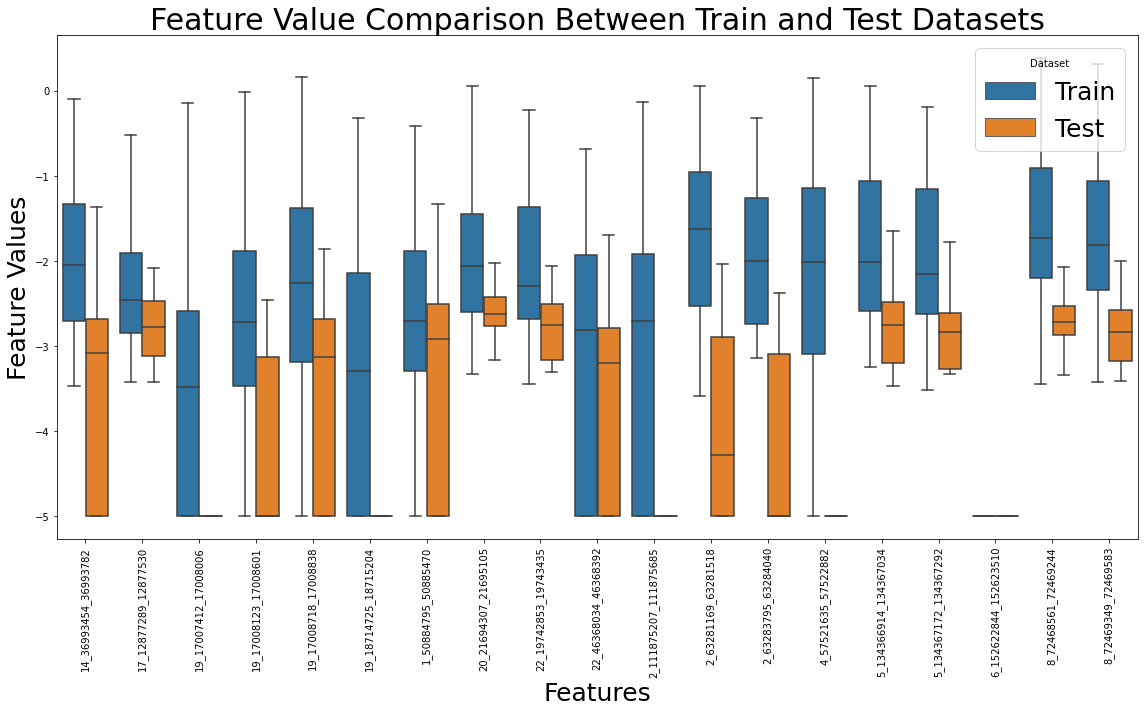

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df_train and df_test are already loaded
# Drop the label column 'sample_type' from df_train
df_train_features = df_train.drop(columns=['sample_type', 'run_sample_id'], errors='ignore')
df_test_features = df_test.drop(columns=['sample_type', 'run_sample_id'], errors='ignore')


# Melt the dataframes for easier visualization
df_train_melted = df_train_features.melt(var_name="Feature", value_name="Value")
df_train_melted["Dataset"] = "Train"

df_test_melted = df_test_features.melt(var_name="Feature", value_name="Value")
df_test_melted["Dataset"] = "Test"

# Combine the datasets
df_combined = pd.concat([df_train_melted, df_test_melted])

# Plot feature distributions using boxplots
plt.figure(figsize=(16, 10))
sns.boxplot(data=df_combined, x="Feature", y="Value", hue="Dataset", showfliers=False)
plt.xticks(rotation=90)
plt.title("Feature Value Comparison Between Train and Test Datasets", fontsize=30)
plt.ylabel("Feature Values", fontsize=25)
plt.xlabel("Features", fontsize=25)
plt.legend(title="Dataset", fontsize=25)
plt.tight_layout()
plt.show()

# Additional sample information about the input data not for the model development 

In [15]:
# Readin Daiichi SOW21 with S3 MB breast caller report by Jing (S3 MB 98% and TFv2 beta)
# df_daiichi_report_1 = pd.read_csv("/ghsfa/projects/pharma/customers/DaiichiSankyoUS/Infinity/DSI_SOW21_Infinity/DSI_SOW21_Infinity_01/data/report/20240430_DaiichiSankyoUS_SOW21_973Samples_InfinityReport.csv", header=1)
# df_daiichi_report_2 = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Infinity/20240625_DaiichiSankyoUS_SOW21_Batch2_177Samples_InfinityReport.csv", header=1)
# df_daiichi_report = pd.concat([df_daiichi_report_1, df_daiichi_report_2])

# TFv2 rule (Breast MB90 and MB18 TFv2 > 0.05%)
df_daiichi_report = pd.read_csv("/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/Treatement_Effect_RUOMRD_CSO_call_05052024/20241021_DSI_SOW21_1150Samples_TFv2_InfinityReport.csv")

df_daiichi_report_new = df_daiichi_report[df_daiichi_report['Sample_status'] == 'SUCCESS']
df_daiichi_report_final = df_daiichi_report_new.drop_duplicates(subset = "GHSampleID")
print(df_daiichi_report_final.shape)

target_sample_list_negative = df_daiichi_report_final[df_daiichi_report_final['Tumor_methylation_status'] == 'Not Detected']['GHSampleID'].values
print('Total Daiichi SOW21 S3 MB breast negative is ' + str(len(target_sample_list_negative)))

target_sample_list_positive = df_daiichi_report_final[df_daiichi_report_final['Tumor_methylation_status'] == 'Detected']['GHSampleID'].values
print('Total Daiichi SOW21 S3 MB breast positive is ' + str(len(target_sample_list_positive)))

(1143, 56)
Total Daiichi SOW21 S3 MB breast negative is 248
Total Daiichi SOW21 S3 MB breast positive is 890


In [33]:
# Readin the RUO/IST data with cancer type and treatment summary that i summarized before
df_ruo_all = pd.read_csv("/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/Treatement_Effect_RUOMRD_CSO_call_05052024/df_all_ruo_new.csv", header = 0)

# Remove the samples with missing mbd_dir
df_ruo_final = df_ruo_all[~df_ruo_all["mbd_dir"].isna()]
print(df_ruo_final.shape)

# Get the DSI SOW21 samples with treatment
dsi_21_id = df_daiichi_report_final.GHSampleID.unique()
df_dsi_sow21_all = df_ruo_final[df_ruo_final['GHSampleID'].isin(dsi_21_id)]
print(df_dsi_sow21_all.treatment.value_counts())

df_dsi_sow21_treatment = df_dsi_sow21_all[df_dsi_sow21_all['treatment'] == 'Treatment']
print("Total size of clinical samples is " + str(df_dsi_sow21_treatment.shape[0]) + "\n") 
print("Total unique sample size of clinical samples is " + str(df_dsi_sow21_treatment.GHSampleID.nunique()) + "\n")
df_dsi_sow21_treatment.head()

(26172, 48)
Baseline     440
Treatment    368
other        304
unknown       14
Name: treatment, dtype: int64
Total size of clinical samples is 368

Total unique sample size of clinical samples is 368



,Study_ID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Sample_status,Sample_comment,cfDNA_ng,Plasma_ml_input,Cancertype,csv_file_name,file_creator,Max_percentage,report_date,Account,SOW_num,cancer_category,cancerstage,cancertype,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,runid,cancerother,fc_dir,Other ID,Conditions,Sponsor,new_defined_cancer_type,treatment,mbd_dir,unique_sample_id
927,DS8201-A-U302,A1023416,B00690294,85232018.0,C04D1,SUCCESS,NaN,12.64,3.0,NaN,20240624_DaiichiSankyoUS_SOW21_Batch2_159Samples_InfinityReport.csv,produser,0.31,2024-06-24,DaiichiSankyoUS,SOW21,Other,NaN,NaN,TCCTAATAGG,Female,Research,2024-06-17 09:03:09-07:00,Sirius_v1.0,NaN,Sirius-1.1.4-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A1023416,cgp,240615_A02019_0122_BHFW32DSXC,NaN,/ghsfa/ivd/flowcentral/240615_A02019_0122_BHFW32DSXC.d1098576-8812-42c9-905c-68cf7d36200a.20240617020221,NaN,NaN,NaN,unknown,Treatment,/ghsfa/ivd/flowcentral/240615_A02019_0122_BHFW32DSXC.d1098576-8812-42c9-905c-68cf7d36200a.20240617020221/B00690294,B00690294_240615_A02019_0122_BHFW32DSXC
928,DS8201-A-U302,A1023417,B00692532,82042003.0,C04D1,SUCCESS,NaN,46.33,3.5,NaN,20240624_DaiichiSankyoUS_SOW21_Batch2_159Samples_InfinityReport.csv,produser,0.39,2024-06-24,DaiichiSankyoUS,SOW21,Other,NaN,NaN,CGATAGGAAT,Female,Research,2024-06-18 13:31:56-07:00,Sirius_v1.0,NaN,Sirius-1.1.4-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A1023417,cgp,240616_A01020_0819_BHFWJVDSXC,NaN,/ghsfa/ivd/flowcentral/240616_A01020_0819_BHFWJVDSXC,NaN,NaN,NaN,unknown,Treatment,/ghsfa/ivd/flowcentral/240616_A01020_0819_BHFWJVDSXC/B00692532,B00692532_240616_A01020_0819_BHFWJVDSXC
929,DS8201-A-U302,A1023418,B00692530,82032014.0,C04D1,SUCCESS,NaN,45.34,3.5,NaN,20240624_DaiichiSankyoUS_SOW21_Batch2_159Samples_InfinityReport.csv,produser,1.86,2024-06-24,DaiichiSankyoUS,SOW21,Other,NaN,NaN,ATCCTCGGGC,Female,Research,2024-06-18 13:31:56-07:00,Sirius_v1.0,NaN,Sirius-1.1.4-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A1023418,cgp,240616_A01020_0819_BHFWJVDSXC,NaN,/ghsfa/ivd/flowcentral/240616_A01020_0819_BHFWJVDSXC,NaN,NaN,NaN,unknown,Treatment,/ghsfa/ivd/flowcentral/240616_A01020_0819_BHFWJVDSXC/B00692530,B00692530_240616_A01020_0819_BHFWJVDSXC
930,DS8201-A-U302,A1023419,B00689846,11112001.0,C04D1,SUCCESS,NaN,36.76,3.0,NaN,20240624_DaiichiSankyoUS_SOW21_Batch2_159Samples_InfinityReport.csv,produser,0.34,2024-06-24,DaiichiSankyoUS,SOW21,Other,NaN,NaN,ACGTATTAAG,Female,Research,2024-06-16 11:44:15-07:00,Sirius_v1.0,NaN,Sirius-1.1.4-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A1023419,cgp,240614_A01810_0400_AHFVLLDSXC,NaN,/ghsfa/ivd/flowcentral/240614_A01810_0400_AHFVLLDSXC,NaN,NaN,NaN,unknown,Treatment,/ghsfa/ivd/flowcentral/240614_A01810_0400_AHFVLLDSXC/B00689846,B00689846_240614_A01810_0400_AHFVLLDSXC
931,DS8201-A-U302,A1023420,B00690470,39152006.0,C04D1,SUCCESS,NaN,38.12,3.0,NaN,20240624_DaiichiSankyoUS_SOW21_Batch2_159Samples_InfinityReport.csv,produser,24.53,2024-06-24,DaiichiSankyoUS,SOW21,Other,NaN,NaN,TCCTAATAGG,Female,Research,2024-06-17 12:04:17-07:00,Sirius_v1.0,NaN,Sirius-1.1.4-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A1023420,cgp,240615_A02056_0167_BHFVTHDSXC,NaN,/ghsfa/ivd/flowcentral/240615_A02056_0167_BHFVTHDSXC.68d765b4-2298-433f-b88c-12f476a1c4b6.20240617050304,NaN,NaN,NaN,unknown,Treatment,/ghsfa/ivd/flowcentral/240615_A02056_0167_BHFVTHDSXC.68d765b4-2298-433f-b88c-12f476a1c4b6.20240617050304/B00690470,B00690470_240615_A02056_0167_BHFVTHDSXC


In [38]:

df_dsi_sow21_treatment_1 = df_dsi_sow21_treatment[df_dsi_sow21_treatment['GHSampleID'] == 'B00478262']
df_dsi_sow21_treatment_1

,Study_ID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Sample_status,Sample_comment,cfDNA_ng,Plasma_ml_input,Cancertype,csv_file_name,file_creator,Max_percentage,report_date,Account,SOW_num,cancer_category,cancerstage,cancertype,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,runid,cancerother,fc_dir,Other ID,Conditions,Sponsor,new_defined_cancer_type,treatment,mbd_dir,unique_sample_id
27236,DS8201-A-U302,A0815479,B00478262,81192008,C04D1,SUCCESS,NaN,12.376,3.0,NaN,20230920_DaiichiSankyoUS_SOW21_973Samples_InfinityReport.csv,jinwang,0.0,2023-09-20,DaiichiSankyoUS,SOW21,Other,NaN,NaN,TCTATCAGAT,Female,Research,2023-09-02 18:24:50-07:00,Sirius_v1.0,NaN,Sirius-1.1.1-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0815479,cgp,230831_A01422_0439_BHCCTYDSX7,NaN,/ghsfa/ivd/flowcentral/230831_A01422_0439_BHCCTYDSX7.e65ee7d6-0afe-4ee3-a7c9-df69e16d3772.20230902112400,NaN,NaN,NaN,unknown,Treatment,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/230831_A01422_0439_BHCCTYDSX7.e65ee7d6-0afe-4ee3-a7c9-df69e16d3772.20230902112400,B00478262_230831_A01422_0439_BHCCTYDSX7


In [ ]:
# Check LR panel regions and generate the data (df_consolidated_clinical_BC_LR_DMR) for DMR analysis

# Create an empty DataFrame for consolidated data
df_consolidated_dsi_treatment_LR_DMR = pd.DataFrame()

# Process each sample
for index, row in df_dsi_sow21_treatment.iterrows():
    run_sample_id = row["GHSampleID"]
    fc_dir = row["mbd_dir"]
    # sample_type = row['CSO_Lung_Sample']
    msre_mr_file = f"{fc_dir}/{run_sample_id}.msre_region_stats.tsv"
    try:
        # Load the data file
        df_temp = pd.read_table(msre_mr_file)
        # Remove control regions in v6
        df_temp_sub = df_temp[~df_temp["region_id"].isin(cso_dmr_remove_coordinate_list)]
        # print(df_temp_sub.shape)

        # Add 'sample_id' and 'sample_type' to the DataFrame
        df_temp_sub['sample_id'] = run_sample_id
        # df_temp_sub['sample_type'] = sample_type
        
        # Append to the consolidated DataFrame
        df_consolidated_dsi_treatment_LR_DMR = pd.concat([df_consolidated_dsi_treatment_LR_DMR, df_temp_sub], ignore_index=True)
    except FileNotFoundError:
        print(f"File not found for sample_id {run_sample_id}: {msre_mr_file}")
        continue

# Get the intermediate component 
df_consolidated_dsi_treatment_LR_DMR['adjusted_log_norm_peak_count'] = np.log10(df_consolidated_dsi_treatment_LR_DMR["norm_peak_count"] + 1e-5)
df_consolidated_dsi_treatment_LR_DMR['adjusted_norm_peak_count'] = df_consolidated_dsi_treatment_LR_DMR["norm_peak_count"] + 1e-5

In [79]:
df_consolidated_dsi_treatment_LR_DMR.run_sample_id.nunique()

162

In [ ]:
# # Readin methyl data of DSI SOW21 s3 MB breast neg samples based on TFv2 rule
# top_prd_df_sub_4 = pd.read_csv(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/Treatement_Effect_RUOMRD_CSO_call_05052024/top_prd_df_sub_4_10212024.csv", header = 0)

In [81]:
# Based on RED team's original lung-tissue specific filter. 19 regions were selected
df_intersection_final_dedup = pd.read_csv("/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/Treatement_Effect_RUOMRD_CSO_call_05052024/df_intersection_final_dedup.csv")

# selection the overlapping regions between LR and healthy-lung-tissue regions for later analysis
region_id_overlap = df_intersection_final_dedup.region_id.unique()
print(region_id_overlap)

df_consolidated_dsi_treatment_LR_DMR_19 = df_consolidated_dsi_treatment_LR_DMR[df_consolidated_dsi_treatment_LR_DMR["region_id"].isin(region_id_overlap)]

# Remove the samples with unexpected region #
count_df = df_consolidated_dsi_treatment_LR_DMR_19.groupby('run_sample_id').region_id.count()

# Filter to find run_sample_id where the count is not 19
not_19_run_sample_ids = count_df[count_df != 19]
print(not_19_run_sample_ids)

# Remove it
df_consolidated_dsi_treatment_LR_DMR_19 = df_consolidated_dsi_treatment_LR_DMR_19[df_consolidated_dsi_treatment_LR_DMR_19['run_sample_id'] != 'A111242801']
print("Total unique sample size of clinical breast cancer inhouse samples with DMR info is " + str(df_consolidated_dsi_treatment_LR_DMR_19.run_sample_id.nunique()) + "\n")

# Save the data
# df_consolidated_clinical_BC_Lung_DMR_19.to_csv(f"{work_dir}/df_consolidated_clinical_BC_Lung_DMR_19_12122024.csv", index = False)

['1_50884795_50885470' '2_63281169_63281518' '2_63283795_63284040'
 '2_111875207_111875685' '4_57521635_57522882' '5_134366914_134367034'
 '5_134367172_134367292' '6_152622844_152623510' '8_72468561_72469244'
 '8_72469349_72469583' '14_36993454_36993782' '17_12877289_12877530'
 '19_17007412_17008006' '19_17008123_17008601' '19_17008718_17008838'
 '19_18714725_18715204' '20_21694307_21695105' '22_19742853_19743435'
 '22_46368034_46368392']
Series([], Name: region_id, dtype: int64)
Total unique sample size of clinical breast cancer inhouse samples with DMR info is 162



In [82]:
df_consolidated_dsi_treatment_LR_DMR_19.head()

,run_sample_id,runid,analysis_version,region_id,num_molecules,peak_cpg,peak_mol,smooth_ctrl,norm_region_count,norm_peak_count,sample_id,adjusted_log_norm_peak_count,adjusted_norm_peak_count
1088,B00690294,240615_A02019_0122_BHFW32DSXC,Sirius-1.1.4-RLS,1_50884795_50885470,1,20,1,1031.74858,0.000019,0.000969,B00690294,-3.009116,0.000979
3234,B00690294,240615_A02019_0122_BHFW32DSXC,Sirius-1.1.4-RLS,2_63281169_63281518,0,0,0,0.00000,0.000000,0.000000,B00690294,-5.000000,0.000010
3235,B00690294,240615_A02019_0122_BHFW32DSXC,Sirius-1.1.4-RLS,2_63283795_63284040,0,0,0,0.00000,0.000000,0.000000,B00690294,-5.000000,0.000010
3658,B00690294,240615_A02019_0122_BHFW32DSXC,Sirius-1.1.4-RLS,2_111875207_111875685,0,0,0,0.00000,0.000000,0.000000,B00690294,-5.000000,0.000010
6559,B00690294,240615_A02019_0122_BHFW32DSXC,Sirius-1.1.4-RLS,4_57521635_57522882,0,0,0,0.00000,0.000000,0.000000,B00690294,-5.000000,0.000010


In [ ]:
# Reformat the test data
df_test = df_consolidated_dsi_treatment_LR_DMR_19.copy()
df_test = df_test[['run_sample_id', 'region_id', 'adjusted_log_norm_peak_count']]

# Pivot the data to make region_id as columns
df_pivot = df_test.pivot(index='run_sample_id', columns='region_id', values='adjusted_log_norm_peak_count')

# Reset the index for a cleaner dataframe
df_test = df_pivot.reset_index()
print(df_test.shape)
# print(df_test.sample_type.value_counts())
df_test.head()

# Save the training data
# df_test.to_csv(f"{work_dir}/df_test.csv", index = False)
df_test.head()


(162, 20)


region_id,run_sample_id,14_36993454_36993782,17_12877289_12877530,19_17007412_17008006,19_17008123_17008601,19_17008718_17008838,19_18714725_18715204,1_50884795_50885470,20_21694307_21695105,22_19742853_19743435,22_46368034_46368392,2_111875207_111875685,2_63281169_63281518,2_63283795_63284040,4_57521635_57522882,5_134366914_134367034,5_134367172_134367292,6_152622844_152623510,8_72468561_72469244,8_72469349_72469583
0,B00689831,-3.111459,-3.147507,-3.441240,-5.00000,-5.000000,-5.000000,-3.406984,-3.125960,-2.827841,-5.000000,-3.147507,-3.117124,-5.000000,-3.114234,-1.815462,-1.876553,-5.0,-2.918862,-5.000000
1,B00689832,-2.662209,-1.770387,-5.000000,-5.00000,-5.000000,-5.000000,-5.000000,-2.255438,-2.493146,-2.330178,-2.985211,-1.583396,-5.000000,-5.000000,-5.000000,-2.985211,-5.0,-2.265467,-2.680317
2,B00689833,-2.186562,-2.723708,-5.000000,-2.50635,-2.071442,-3.324114,-5.000000,-2.170317,-2.178358,-2.555662,-2.696947,-1.724010,-2.081579,-2.742583,-2.745812,-2.722868,-5.0,-2.138728,-2.084816
3,B00689834,-2.356072,-1.980228,-2.757998,-5.00000,-2.665414,-5.000000,-5.000000,-2.110093,-2.501805,-3.235407,-5.000000,-2.333587,-2.467799,-2.369438,-2.298203,-2.390370,-5.0,-1.971303,-2.101062
4,B00689835,-1.240730,-2.240927,-5.000000,-5.00000,-2.181476,-2.632594,-1.154844,-1.797283,-1.750777,-2.034309,-1.843442,-1.140846,-1.454614,-1.218886,-2.330228,-2.332469,-5.0,-1.132602,-1.096560


In [89]:
# Load the saved scaler, model, and threshold
scaler = joblib.load(scaler_path)
final_LR_model = joblib.load(model_path)
threshold = joblib.load(threshold_path)
print(threshold)

# Prepare test data
X_future = df_test.drop(['run_sample_id'], axis=1)
# X_future_imputed = X_future.fillna(X_future.median())
X_future_scaled = scaler.transform(X_future)

# Predict probabilities
y_pred_proba = final_LR_model.predict_proba(X_future_scaled)[:, 1]

# Apply custom threshold
# threshold = 0.01
y_pred_class = (y_pred_proba >= threshold).astype(int)

# Add predictions to the dataframe
df_test_1 = df_test.copy()
df_test_1['Prediction_Probability'] = y_pred_proba
df_test_1['Prediction_Class'] = y_pred_class

# Display predictions
print(df_test_1[['Prediction_Probability', 'Prediction_Class']].head())


0.3520960407003127
region_id  Prediction_Probability  Prediction_Class
0                    2.079219e-08                 0
1                    2.643936e-07                 0
2                    5.310651e-07                 0
3                    2.925468e-07                 0
4                    8.958121e-05                 0


In [90]:
df_test_2 = df_test_1[["Prediction_Probability", "Prediction_Class"]]
df_test_2

region_id,Prediction_Probability,Prediction_Class
0,2.079219e-08,0
1,2.643936e-07,0
2,5.310651e-07,0
3,2.925468e-07,0
4,8.958121e-05,0
5,8.206860e-08,0
6,2.328875e-04,0
7,1.095871e-06,0
8,1.091547e-07,0
9,2.571554e-06,0


In [87]:
df_test.shape

(162, 20)

In [38]:
df_complete_dsi_na = df_complete_dsi[df_complete_dsi["mbd_dir"].isna()]
df_complete_dsi_na

,Study_ID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Sample_status,Sample_comment,cfDNA_ng,Plasma_ml_input,Cancertype,csv_file_name,file_creator,Max_percentage,report_date,Account,SOW_num,cancer_category,cancerstage,cancertype,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,runid,cancerother,fc_dir,Other ID,Conditions,Sponsor,new_defined_cancer_type,treatment,mbd_dir,unique_sample_id
27443,DS8201-A-U302,A0815481,B00478226,81282011,EOT,SUCCESS,NaN,113.360,3.0,NaN,20230920_DaiichiSankyoUS_SOW21_973Samples_InfinityReport.csv,jinwang,2.92,2023-09-20,DaiichiSankyoUS,SOW21,Other,NaN,NaN,TTGACAATTC,Female,Research,2023-09-02 18:28:20-07:00,Sirius_v1.0,NaN,Sirius-1.1.1-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0815481,cgp,230831_A01422_0440_AHCH7YDSX7,NaN,/ghsfa/ivd/flowcentral/230831_A01422_0440_AHCH7YDSX7,NaN,NaN,NaN,unknown,other,NaN,B00478226_230831_A01422_0440_AHCH7YDSX7
27444,DS8201-A-U302,A0815482,B00478227,81042008,EOT,SUCCESS,NaN,43.212,3.0,NaN,20230920_DaiichiSankyoUS_SOW21_973Samples_InfinityReport.csv,jinwang,9.26,2023-09-20,DaiichiSankyoUS,SOW21,Other,NaN,NaN,TGGCCTGAGC,Female,Research,2023-09-04 22:41:07-07:00,Sirius_v1.0,NaN,Sirius-1.1.1-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0815482,cgp,230902_A01422_0442_BHCCH3DSX7,NaN,/ghsfa/ivd/flowcentral/230902_A01422_0442_BHCCH3DSX7.edc38c2f-dd73-4f67-95b8-26ba75adf07e.20230904154008,NaN,NaN,NaN,unknown,other,NaN,B00478227_230902_A01422_0442_BHCCH3DSX7
27445,DS8201-A-U302,A0815483,B00478224,81182003,EOT,SUCCESS,NaN,152.880,3.0,NaN,20230920_DaiichiSankyoUS_SOW21_973Samples_InfinityReport.csv,jinwang,1.55,2023-09-20,DaiichiSankyoUS,SOW21,Other,NaN,NaN,TATAAGGTCC,Female,Research,2023-09-02 18:28:20-07:00,Sirius_v1.0,NaN,Sirius-1.1.1-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0815483,cgp,230831_A01422_0440_AHCH7YDSX7,NaN,/ghsfa/ivd/flowcentral/230831_A01422_0440_AHCH7YDSX7,NaN,NaN,NaN,unknown,other,NaN,B00478224_230831_A01422_0440_AHCH7YDSX7
27446,DS8201-A-U302,A0815484,B00478225,81172006,EOT,SUCCESS,NaN,25.896,3.0,NaN,20230920_DaiichiSankyoUS_SOW21_973Samples_InfinityReport.csv,jinwang,0.28,2023-09-20,DaiichiSankyoUS,SOW21,Other,NaN,NaN,AGCTTTAAAT,Female,Research,2023-09-04 22:41:07-07:00,Sirius_v1.0,NaN,Sirius-1.1.1-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0815484,cgp,230902_A01422_0442_BHCCH3DSX7,NaN,/ghsfa/ivd/flowcentral/230902_A01422_0442_BHCCH3DSX7.edc38c2f-dd73-4f67-95b8-26ba75adf07e.20230904154008,NaN,NaN,NaN,unknown,other,NaN,B00478225_230902_A01422_0442_BHCCH3DSX7
27447,DS8201-A-U302,A0815485,B00478235,81172002,EOT,SUCCESS,NaN,41.132,3.0,NaN,20230920_DaiichiSankyoUS_SOW21_973Samples_InfinityReport.csv,jinwang,2.62,2023-09-20,DaiichiSankyoUS,SOW21,Other,NaN,NaN,TGCGATGGTT,Female,Research,2023-09-04 22:41:07-07:00,Sirius_v1.0,NaN,Sirius-1.1.1-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0815485,cgp,230902_A01422_0442_BHCCH3DSX7,NaN,/ghsfa/ivd/flowcentral/230902_A01422_0442_BHCCH3DSX7.edc38c2f-dd73-4f67-95b8-26ba75adf07e.20230904154008,NaN,NaN,NaN,unknown,other,NaN,B00478235_230902_A01422_0442_BHCCH3DSX7
27448,DS8201-A-U302,A0815486,B00478238,81022011,EOT,SUCCESS,NaN,47.788,3.0,NaN,20230920_DaiichiSankyoUS_SOW21_973Samples_InfinityReport.csv,jinwang,0.89,2023-09-20,DaiichiSankyoUS,SOW21,Other,NaN,NaN,TGTCGCCCTT,Female,Research,2023-09-02 18:28:20-07:00,Sirius_v1.0,NaN,Sirius-1.1.1-RLS,NaN,NaN,Guardant 360,DSI_21,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A0815486,cgp,230831_A01422_0440_AHCH7YDSX7,NaN,/ghsfa/ivd/flowcentral/230831_A01422_0440_AHCH7YDSX7,NaN,NaN,NaN,unknown,other,NaN,B00478238_230831_A01422_0440_AHCH7YDSX7
27449,DS8201-A-U302,A0815487,B00478230,81082015,EOT,SUCCESS,NaN,410.280,3.0,NaN,20230920_DaiichiSankyoUS_SOW21_973Samples_InfinityReport.csv,ji

In [5]:
# Readin data and remove missing "mbd_dir"
df_complete_6 = pd.read_csv("/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/Treatement_Effect_RUOMRD_CSO_call_05052024/df_all_ruo_new.csv", header = 0)

df_complete_7 = df_complete_6[~df_complete_6["mbd_dir"].isna()]
print(df_complete_7.shape)
df_complete_7.head()

(26172, 48)


,Study_ID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Sample_status,Sample_comment,cfDNA_ng,Plasma_ml_input,Cancertype,csv_file_name,file_creator,Max_percentage,report_date,Account,SOW_num,cancer_category,cancerstage,cancertype,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,runid,cancerother,fc_dir,Other ID,Conditions,Sponsor,new_defined_cancer_type,treatment,mbd_dir,unique_sample_id
0,C4221015,A1059361,B00697309,13231002,Cycle 7 Day 1,SUCCESS,NaN,43.58,4.0,NaN,20240628_Pfizer_SOW46Amendment1TP4_Batch3_38Samples_G360Report.csv,produser,NaN,2024-06-28,Pfizer,SOW46Amendment1TP4,Other,NaN,NaN,TAGGATTAGC,Unknown,Research,2024-06-25 23:19:45-07:00,Sirius_v1.0,NaN,Sirius-1.1.4-RLS,NaN,NaN,Guardant 360,PFE_46_Infinity_TP4,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A1059361,cgp,240623_A02048_0178_AHG2WKDSXC,NaN,/ghsfa/ivd/flowcentral/240623_A02048_0178_AHG2WKDSXC.3eacfbb1-6919-4e7e-a4a2-b4fa0936fe28.20240625161857,NaN,NaN,NaN,unknown,Baseline,/ghsfa/ivd/flowcentral/240623_A02048_0178_AHG2WKDSXC.3eacfbb1-6919-4e7e-a4a2-b4fa0936fe28.20240625161857/B00697309,B00697309_240623_A02048_0178_AHG2WKDSXC
1,C4221015,A1059362,B00697306,12021005,Cycle 7 Day 1,SUCCESS,NaN,12.43,3.0,NaN,20240628_Pfizer_SOW46Amendment1TP4_Batch3_38Samples_G360Report.csv,produser,NaN,2024-06-28,Pfizer,SOW46Amendment1TP4,Other,NaN,NaN,AGAGCGCCCT,Unknown,Research,2024-06-25 23:19:45-07:00,Sirius_v1.0,NaN,Sirius-1.1.4-RLS,NaN,NaN,Guardant 360,PFE_46_Infinity_TP4,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A1059362,cgp,240623_A02048_0178_AHG2WKDSXC,NaN,/ghsfa/ivd/flowcentral/240623_A02048_0178_AHG2WKDSXC.3eacfbb1-6919-4e7e-a4a2-b4fa0936fe28.20240625161857,NaN,NaN,NaN,unknown,Baseline,/ghsfa/ivd/flowcentral/240623_A02048_0178_AHG2WKDSXC.3eacfbb1-6919-4e7e-a4a2-b4fa0936fe28.20240625161857/B00697306,B00697306_240623_A02048_0178_AHG2WKDSXC
2,C4221015,A1059363,B00697324,10341005,Cycle 7 Day 1,SUCCESS,NaN,119.60,3.5,NaN,20240628_Pfizer_SOW46Amendment1TP4_Batch3_38Samples_G360Report.csv,produser,NaN,2024-06-28,Pfizer,SOW46Amendment1TP4,Other,NaN,NaN,GCAGGTCAGT,Unknown,Research,2024-06-25 23:19:45-07:00,Sirius_v1.0,NaN,Sirius-1.1.4-RLS,NaN,NaN,Guardant 360,PFE_46_Infinity_TP4,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A1059363,cgp,240623_A02048_0178_AHG2WKDSXC,NaN,/ghsfa/ivd/flowcentral/240623_A02048_0178_AHG2WKDSXC.3eacfbb1-6919-4e7e-a4a2-b4fa0936fe28.20240625161857,NaN,NaN,NaN,unknown,Baseline,/ghsfa/ivd/flowcentral/240623_A02048_0178_AHG2WKDSXC.3eacfbb1-6919-4e7e-a4a2-b4fa0936fe28.20240625161857/B00697324,B00697324_240623_A02048_0178_AHG2WKDSXC
3,C4221015,A1059364,B00697321,13161010,Cycle 9 Day 1,SUCCESS,NaN,11.70,4.0,NaN,20240628_Pfizer_SOW46Amendment1TP4_Batch3_38Samples_G360Report.csv,produser,NaN,2024-06-28,Pfizer,SOW46Amendment1TP4,Other,NaN,NaN,TTCGAGCCAG,Unknown,Research,2024-06-25 23:19:45-07:00,Sirius_v1.0,NaN,Sirius-1.1.4-RLS,NaN,NaN,Guardant 360,PFE_46_Infinity_TP4,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A1059364,cgp,240623_A02048_0178_AHG2WKDSXC,NaN,/ghsfa/ivd/flowcentral/240623_A02048_0178_AHG2WKDSXC.3eacfbb1-6919-4e7e-a4a2-b4fa0936fe28.20240625161857,NaN,NaN,NaN,unknown,Baseline,/ghsfa/ivd/flowcentral/240623_A02048_0178_AHG2WKDSXC.3eacfbb1-6919-4e7e-a4a2-b4fa0936fe28.20240625161857/B00697321,B00697321_240623_A02048_0178_AHG2WKDSXC
4,C4221015,A1059365,B00697319,12331006,Cycle 7 Day 1,SUCCESS,NaN,28.65,4.0,NaN,20240628_Pfizer_SOW46Amendment1TP4_Batch3_38Samples_G360Report.csv,produser,NaN,2024-06-28,Pfizer,SOW46Amendment1TP4,Other,NaN,NaN,CGGAGCAATG,Unknown,Research,2024-06-25 23:19:45-07:00,Sirius_v1.0,NaN,Sirius-1.1.4-RLS,NaN,NaN,Guardant 360,PFE_46_Infinity_TP4,NaN,NaN,Sirius_LDT_Soft_v2.0,NaN,NaN,NaN,A1059365,cgp,240623_A02048_0178_AHG2WKDSXC,NaN,/ghsfa/ivd/flowcentral/240623_A02048_0178_AHG2WKDSXC.3eacfbb1-6919-4e7e-a4a2-b4fa0936fe28.20240625161857,NaN,NaN,NaN,unknown,Baseline,/ghsfa/ivd/flowcentral/240623_